<a href="https://colab.research.google.com/github/Madfuuu/Coursera_Capstone/blob/main/Capstone_project_Helsinki_house_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone project, Helsinki house prices

### In this workbook we will explore the housing prices according to different postal code areas in the Greater Helsinki area. Then we will try to figure out what variables have the biggest affect for high housing prices. We will NOT study about the actual house or property qualitites, but strictly focus on external factors like location and distance to venues. 
#### We will use free for use data which can be retrieved from Finnish government provided www.hri.fi  and www.stat.fi websites. In this book we will use Foursquare, folium choropleth maps, lots of Pandas and geoPandas dataframes and also get used to retrieving and cleaning data from .csv files. 

### The process

1. Download and import necessary libraries
2. Retrieve, clean and combine needed data
3. Use Foursquare API to retrieve further data for our analysis
4. a. Create Choropleth map to the visualize the price differences between areas\
   b. Create another Cloropleth map that includes train station locations and HSL Zones
5. a. Use K-Means clustering with location price data, distance from train station and HSL zone\
   b. Use K-Means clustering with data retrieved from Foursquare \
   c. Use K-Means clustering with both the public transportation data and Foursquare data
6. Analyze the data 

### 1. Download and import necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab files/Capstone/tilastot

/content/drive/MyDrive/Colab files/Capstone/tilastot


In [3]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [4]:
import condacolab
condacolab.check()


✨🍰✨ Everything looks OK!


In [5]:
#Import useful libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
!pip install pygeoj #A library to load geoJSON files
import pygeoj

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Install folium
!conda install -c conda-forge folium --yes
import folium

# Needed for webscraping
!pip install bs4
from bs4 import BeautifulSoup

# Needed for creating choropleth maps
!conda install -c plotly plotly=4.14.3 --yes
import plotly.express as px
!pip install pyshp==1.2.10
!pip install shapely==1.6.3

# Needed for practicing Plotly choropleth map
from urllib.request import urlopen

# Needed for retrieving zipcodes from coordinate data
!pip install geopandas
import geopandas as gpd
!pip install geopy
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

print('Libraries imported.')

# Libraries for plottin data and ding data analysis
! pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from scipy import stats

# For linear regression model
from sklearn.linear_model import LinearRegression

Solving environment: \ | / - \ | / - \ | done

# All requested packages already installed.

Solving environment: / - \ | / - \ | / - \ | / - \ done

# All requested packages already installed.

Solving environment: | / - \ | / - \ | / - \ | done

# All requested packages already installed.

Libraries imported.



### 2. Retrieve and clean needed data 
First we need data that we will use for the analysis and visualization.
We will need housing price data for Greater Helsinki area that is divided into postal areas.
We will also get the locations for the trains and metros in Helsinki area.
The data also needs be cleaned before it can but into use.

In [6]:
df = pd.read_csv("master_data_correct_years.csv",sep=',',dtype={"posti_alue": str,"vuosi":int})

In [7]:
df.head(10)

posti_alue             nimi  vuosi  he_vakiy  he_miehet  he_naiset  he_kika  \
0      04840        Hautjärvi   2013     254.0      122.0      132.0     42.0   
1      04920       Saarentaus   2013     336.0      174.0      162.0     40.0   
2      05800  Hyvinkää Keskus   2013    9268.0     4190.0     5078.0     47.0   
3      05820    Mustamännistö   2013    5076.0     2575.0     2501.0     39.0   
4      07560   Pukkila Keskus   2013    1421.0      702.0      719.0     42.0   
5      07600  Myrskylä Keskus   2013    1730.0      860.0      870.0     45.0   
6      07820         Porlammi   2013     535.0      265.0      270.0     48.0   
7      07830           Pukaro   2013     305.0      160.0      145.0     43.0   
8      09220         Sammatti   2013    1626.0      806.0      820.0     40.0   
9      09810     Nummi-Oinola   2013     999.0      493.0      506.0     45.0   

   he_0_2  he_3_6  he_7_12  he_13_15  he_16_17  he_18_19  he_20_24  he_25_29  \
0    12.0     7.0     14.0      12.0       8.0       7.0      10.0       7.0   
1    11.0    18.0     29.0      13.0       9.0       5.0      13.0      13.0   
2   190.0   221.0    368.0     200.0     153.0     250.0     713.0     592.0   
3   171.0   268.0    421.0     227.0     160.0     143.0     228.0     215.0   
4    42.0    67.0    116.0      66.0      34.0      26.0      61.0      51.0   
5    47.0    68.0    111.0      56.0      41.0      47.0      69.0      82.0   
6    11.0    19.0     26.0      15.0      14.0      10.0      13.0      23.0   
7     5.0    14.0     21.0      17.0       6.0       7.0       9.0      10.0   
8    58.0   104.0    144.0      69.0      40.0      21.0      56.0      66.0   
9    34.0    48.0     53.0      36.0      26.0      21.0      33.0      33.0   

   he_30_34  he_35_39  he_40_44  he_45_49  he_50_54  he_55_59  he_60_64  \
0      15.0      19.0      16.0      21.0      26.0      22.0      12.0   
1      20.0      28.0      25.0      23.0      31.0      27.0      25.0   
2     531.0     466.0     450.0     534.0     640.0     632.0     701.0   
3     318.0     358.0     359.0     413.0     422.0     336.0     312.0   
4      69.0      78.0     106.0     123.0      92.0     105.0      78.0   
5      92.0      70.0     105.0     113.0     132.0     122.0     142.0   
6      28.0      15.0      29.0      39.0      45.0      51.0      38.0   
7      25.0      16.0      14.0      22.0      35.0      20.0      24.0   
8      89.0     128.0     119.0      97.0      95.0     117.0     127.0   
9      47.0      80.0      59.0      52.0      66.0      76.0      84.0   

   he_65_69  he_70_74  he_75_79  he_80_84  he_85_  tp_tyopy  tp_alku_a  \
0      12.0      12.0      13.0       5.0     4.0      42.0       16.0   
1      10.0      14.0      12.0       5.0     5.0     185.0        9.0   
2     751.0     541.0     495.0     438.0   402.0    7215.0       16.0   
3     270.0     166.0     123.0      89.0    77.0     858.0        8.0   
4     108.0      67.0      53.0      35.0    44.0     344.0       46.0   
5     142.0      89.0      80.0      62.0    60.0     397.0       67.0   
6      56.0      35.0      26.0      20.0    22.0     124.0       43.0   
7      17.0       9.0      15.0      14.0     5.0     145.0       43.0   
8     109.0      67.0      47.0      42.0    31.0     350.0       27.0   
9      77.0      41.0      38.0      46.0    49.0     177.0       26.0   

   tp_jalo_bf  tp_palv_gu  tp_a_maat  tp_b_kaiv  tp_c_teol  tp_d_ener  \
0         3.0        23.0       16.0        0.0        0.0        0.0   
1        14.0       162.0        9.0        0.0        1.0        0.0   
2      1563.0      5636.0       16.0        0.0      868.0       27.0   
3       419.0       431.0        8.0        0.0      294.0        0.0   
4        96.0       202.0       46.0        0.0       19.0        0.0   
5        85.0       245.0       67.0        2.0       47.0        0.0   
6        23.0        58.0       43.0        0.0       16.0        0.0   
7   

In [8]:
%cd /content/drive/MyDrive/Colab files/Capstone
#Name of the dataset from stat.fi 'Average prices of old dwellings in housing companies (eur/m2) and numbers of transactions by postal code area and year of construction by Building type, Year of construction, Postal code, Year and Information'
#Get the Greater Helsinki housing price data
old_price_df = pd.read_csv("greater_helsinki_house_prices.csv",encoding = "ISO-8859-1",sep=';',header=1,dtype={"fips": str})


# Drop useless columns
old_price_df=old_price_df.drop(['Talotyyppi','Rakennusvuosi'],axis=1)

# Make the dataframe prettier and clearer by dividing data into separate columns
old_price_df[['Zip', 'Neighborhood']] = old_price_df['Postinumero'].str.split(' ', n=1, expand=True)
old_price_df[['Neighborhood1','City']] = old_price_df['Neighborhood'].str.split('(', expand=True)
old_price_df['City']=old_price_df['City'].str.replace(")","")
old_price_df=old_price_df.drop(['Neighborhood','Postinumero'],axis=1)
old_price_df=old_price_df.rename(columns={'Neighborhood1':'Neighborhood'})

# Reorder the columns so that Zip, neighborhood and city are before the price data
cols = old_price_df.columns.tolist() #get the columns to cols
cols = cols[-3:] + cols[:-3]  #Reorder, first get 3 last columns and then everything before the third last column
old_price_df = old_price_df[cols]

# Rename the columns simpler and more understandable
old_price_df=old_price_df.rename(columns={'2010 Neliöhinta (EUR/m2)':2010,
              '2011 Neliöhinta (EUR/m2)':2011,
              '2012 Neliöhinta (EUR/m2)':2012,
              '2013 Neliöhinta (EUR/m2)':2013,
              '2014 Neliöhinta (EUR/m2)':2014,
              '2015 Neliöhinta (EUR/m2)':2015,
              '2016 Neliöhinta (EUR/m2)':2016,
              '2017 Neliöhinta (EUR/m2)':2017,
              '2018 Neliöhinta (EUR/m2)':2018,
              '2019 Neliöhinta (EUR/m2)':2019,
              '2020 Neliöhinta (EUR/m2)':2020})
old_price_df.head()

/content/drive/MyDrive/Colab files/Capstone


Zip                      Neighborhood       City  2010  2011  2012  2013  \
0  00100  Helsinki Keskusta - Etu-Töölö     Helsinki   5208  5661  5874  6012   
1  00120                      Punavuori     Helsinki   5554  5620  5911  6286   
2  00130                Kaartinkaupunki     Helsinki   5388  6681  6201  6680   
3  00140       Kaivopuisto - Ullanlinna     Helsinki   5835  6347  6349  6667   
4  00150              Eira - Hernesaari     Helsinki   5364  5809  5860  6390   

   2014  2015  2016  2017  2018  2019  2020  
0  6116  6130  5774  6738  7038  7336  7587  
1  6009  6424  6539  7047  7526  7726  8182  
2  6987  6368  7553  7393  7938  8193  7855  
3  6700  6746  7137  7465  7945  8525  8712  
4  6578  6579  6715  7261  7663  8013  8401

In [9]:
# THIS PROCESSING WAS TOO MUCH FOR MY PC, SO HERE IS WHEN I CHANGED MY NOTEBOOK TO GOOGLE COLAB CLOUD PLATFORM.
# In another notebook that is not here, some further processing was done 

#postalcodes_statistics_json = gpd.read_file("postinumerot2021+tilastot.geojson")
#postalcodes_statistics_json= postalcodes_statistics_json.drop(['namn','euref_x','euref_y','pinta_ala','vuosi','kunta','he_naiset','he_miehet','he_0_2','he_3_6','he_7_12','he_13_15','he_16_17','he_50_54','he_55_59','he_60_64','he_65_69','he_70_74','he_75_79','he_80_84','ko_ika18y','hr_mtu','hr_ovy','te_taly','te_as_valj','te_yks','te_nuor','te_eil_np','te_laps','te_plap','te_aklap','te_klap','te_teini','te_yhlap','te_aik','te_elak','te_omis_as','te_vuok_as','te_muu_as','tr_kuty','tr_ktu','tr_mtu','tr_pi_tul','tr_ke_tul','tr_hy_tul','tr_ovy','ra_ke','ra_asrak','ra_muut','ra_asunn','ra_as_kpa','ra_pt_as','ra_kt_as','tp_tyopy','tp_alku_a','tp_jalo_bf','tp_palv_gu','tp_a_maat','tp_b_kaiv','tp_c_teol','tp_d_ener','tp_e_vesi','tp_f_rake','tp_g_kaup','tp_h_kulj','tp_i_majo','tp_j_info','tp_k_raho','tp_l_kiin','tp_m_erik','tp_n_hall','tp_o_julk','tp_p_koul','tp_q_terv','tp_r_taid','tp_s_muup','tp_t_koti','tp_u_kans','tp_x_tunt','pt_0_14','pt_muut'],axis=1)
#postalcodes_statistics_json=postalcodes_statistics_json.rename(columns={'he_kika':'avg. age','ko_perus':'basic studies lvl','ko_koul':'upper secondary lvl','ko_yliop':'matriculation lvl','ko_ammat':'vocational diploma','ko_al_kork':'lower lvl uni','ko_yl_kork':'upper lvl uni','hr_tuy':'pop. aged over 18','hr_ktu':'avg. income/inhabitat','hr_ktu':'lowest income category pop.','hr_ke_tul':'middle income category pop.','hr_hy_tul':'highest income category pop.','te_takk':'avg. household size','ra_raky':'buildings, total','pt_vakiy':'perm. inhab.','pt_tyoll':'employed inhab.','pt_tyott':'unemployed inhab.','pt_opisk':'student inhab.','pt_elakel':'retired inhab.'}).astype(str)
#print('done')

# The processed data
postalcode_geodf =gpd.read_file("postalcodes_statistics_dropped_renamed.geojson")
df.head()


posti_alue             nimi  vuosi  he_vakiy  he_miehet  he_naiset  he_kika  \
0      04840        Hautjärvi   2013     254.0      122.0      132.0     42.0   
1      04920       Saarentaus   2013     336.0      174.0      162.0     40.0   
2      05800  Hyvinkää Keskus   2013    9268.0     4190.0     5078.0     47.0   
3      05820    Mustamännistö   2013    5076.0     2575.0     2501.0     39.0   
4      07560   Pukkila Keskus   2013    1421.0      702.0      719.0     42.0   

   he_0_2  he_3_6  he_7_12  he_13_15  he_16_17  he_18_19  he_20_24  he_25_29  \
0    12.0     7.0     14.0      12.0       8.0       7.0      10.0       7.0   
1    11.0    18.0     29.0      13.0       9.0       5.0      13.0      13.0   
2   190.0   221.0    368.0     200.0     153.0     250.0     713.0     592.0   
3   171.0   268.0    421.0     227.0     160.0     143.0     228.0     215.0   
4    42.0    67.0    116.0      66.0      34.0      26.0      61.0      51.0   

   he_30_34  he_35_39  he_40_44  he_45_49  he_50_54  he_55_59  he_60_64  \
0      15.0      19.0      16.0      21.0      26.0      22.0      12.0   
1      20.0      28.0      25.0      23.0      31.0      27.0      25.0   
2     531.0     466.0     450.0     534.0     640.0     632.0     701.0   
3     318.0     358.0     359.0     413.0     422.0     336.0     312.0   
4      69.0      78.0     106.0     123.0      92.0     105.0      78.0   

   he_65_69  he_70_74  he_75_79  he_80_84  he_85_  tp_tyopy  tp_alku_a  \
0      12.0      12.0      13.0       5.0     4.0      42.0       16.0   
1      10.0      14.0      12.0       5.0     5.0     185.0        9.0   
2     751.0     541.0     495.0     438.0   402.0    7215.0       16.0   
3     270.0     166.0     123.0      89.0    77.0     858.0        8.0   
4     108.0      67.0      53.0      35.0    44.0     344.0       46.0   

   tp_jalo_bf  tp_palv_gu  tp_a_maat  tp_b_kaiv  tp_c_teol  tp_d_ener  \
0         3.0        23.0       16.0        0.0        0.0        0.0   
1        14.0       162.0        9.0        0.0        1.0        0.0   
2      1563.0      5636.0       16.0        0.0      868.0       27.0   
3       419.0       431.0        8.0        0.0      294.0        0.0   
4        96.0       202.0       46.0        0.0       19.0        0.0   

   tp_e_vesi  tp_f_rake  tp_g_kaup  tp_h_kulj  tp_i_majo  tp_j_info  \
0        0.0        3.0        2.0       21.0        0.0        0.0   
1        2.0       11.0        5.0       15.0        0.0        0.0   
2       27.0      641.0     1545.0      247.0      413.0       75.0   
3        0.0      125.0       80.0       65.0       39.0        3.0   
4        0.0       77.0       27.0       34.0       10.0        2.0   

   tp_k_raho  tp_l_kiin  tp_m_erik  tp_n_hall  tp_o_julk  tp_p_koul  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        1.0        2.0        0.0        0.0        0.0      132.0   
2      198.0      121.0      235.0      248.0      214.0      617.0   
3        0.0        8.0       40.0       20.0        2.0       56.0   
4        5.0        1.0       14.0       14.0       19.0       27.0   

   tp_q_terv  tp_r_taid  tp_s_muup  tp_t_koti  tp_u_kans  tp_x_tunt  pt_vakiy  \
0        0.0        0.0        0.0        0.0        0.0        0.0     254.0   
1        7.0        0.0        0.0        0.0        0.0        0.0     336.0   
2     1260.0      198.0      265.0        0.0        0.0        0.0    9268.0   
3       91.0        6.0       21.0        0.0        0.0        0.0    5073.0   
4       33.0        2.0       14.0        0.0        0.0        0.0    1421.0   

   pt_tyoll  pt_tyott  pt_0_14  pt_opisk  pt_elakel  pt_muut  \
0     123.0       7.0     40.0      22.0       55.0      7.0   
1     167.0      12.0     68.0      13.0       62.0     14.0   
2    3928.0     509.0    921.0     547.0     3105.0    258.0   
3    2321.0     257.0   1017.0     382.0      936.0    160.0   
4     624.0      61.0    268.0      83

In [10]:
postalcode_geodf=postalcode_geodf.rename(columns={'postinumeroalue':'posti_alue'}).astype(str)
df=df.merge(postalcode_geodf[['posti_alue','geometry']],on="posti_alue")
df.head()

posti_alue             nimi  vuosi  he_vakiy  he_miehet  he_naiset  he_kika  \
0      04840        Hautjärvi   2013     254.0      122.0      132.0     42.0   
1      04920       Saarentaus   2013     336.0      174.0      162.0     40.0   
2      05800  Hyvinkää Keskus   2013    9268.0     4190.0     5078.0     47.0   
3      05820    Mustamännistö   2013    5076.0     2575.0     2501.0     39.0   
4      07560   Pukkila Keskus   2013    1421.0      702.0      719.0     42.0   

   he_0_2  he_3_6  he_7_12  he_13_15  he_16_17  he_18_19  he_20_24  he_25_29  \
0    12.0     7.0     14.0      12.0       8.0       7.0      10.0       7.0   
1    11.0    18.0     29.0      13.0       9.0       5.0      13.0      13.0   
2   190.0   221.0    368.0     200.0     153.0     250.0     713.0     592.0   
3   171.0   268.0    421.0     227.0     160.0     143.0     228.0     215.0   
4    42.0    67.0    116.0      66.0      34.0      26.0      61.0      51.0   

   he_30_34  he_35_39  he_40_44  he_45_49  he_50_54  he_55_59  he_60_64  \
0      15.0      19.0      16.0      21.0      26.0      22.0      12.0   
1      20.0      28.0      25.0      23.0      31.0      27.0      25.0   
2     531.0     466.0     450.0     534.0     640.0     632.0     701.0   
3     318.0     358.0     359.0     413.0     422.0     336.0     312.0   
4      69.0      78.0     106.0     123.0      92.0     105.0      78.0   

   he_65_69  he_70_74  he_75_79  he_80_84  he_85_  tp_tyopy  tp_alku_a  \
0      12.0      12.0      13.0       5.0     4.0      42.0       16.0   
1      10.0      14.0      12.0       5.0     5.0     185.0        9.0   
2     751.0     541.0     495.0     438.0   402.0    7215.0       16.0   
3     270.0     166.0     123.0      89.0    77.0     858.0        8.0   
4     108.0      67.0      53.0      35.0    44.0     344.0       46.0   

   tp_jalo_bf  tp_palv_gu  tp_a_maat  tp_b_kaiv  tp_c_teol  tp_d_ener  \
0         3.0        23.0       16.0        0.0        0.0        0.0   
1        14.0       162.0        9.0        0.0        1.0        0.0   
2      1563.0      5636.0       16.0        0.0      868.0       27.0   
3       419.0       431.0        8.0        0.0      294.0        0.0   
4        96.0       202.0       46.0        0.0       19.0        0.0   

   tp_e_vesi  tp_f_rake  tp_g_kaup  tp_h_kulj  tp_i_majo  tp_j_info  \
0        0.0        3.0        2.0       21.0        0.0        0.0   
1        2.0       11.0        5.0       15.0        0.0        0.0   
2       27.0      641.0     1545.0      247.0      413.0       75.0   
3        0.0      125.0       80.0       65.0       39.0        3.0   
4        0.0       77.0       27.0       34.0       10.0        2.0   

   tp_k_raho  tp_l_kiin  tp_m_erik  tp_n_hall  tp_o_julk  tp_p_koul  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        1.0        2.0        0.0        0.0        0.0      132.0   
2      198.0      121.0      235.0      248.0      214.0      617.0   
3        0.0        8.0       40.0       20.0        2.0       56.0   
4        5.0        1.0       14.0       14.0       19.0       27.0   

   tp_q_terv  tp_r_taid  tp_s_muup  tp_t_koti  tp_u_kans  tp_x_tunt  pt_vakiy  \
0        0.0        0.0        0.0        0.0        0.0        0.0     254.0   
1        7.0        0.0        0.0        0.0        0.0        0.0     336.0   
2     1260.0      198.0      265.0        0.0        0.0        0.0    9268.0   
3       91.0        6.0       21.0        0.0        0.0        0.0    5073.0   
4       33.0        2.0       14.0        0.0        0.0        0.0    1421.0   

   pt_tyoll  pt_tyott  pt_0_14  pt_opisk  pt_elakel  pt_muut  \
0     123.0       7.0     40.0      22.0       55.0      7.0   
1     167.0      12.0     68.0      13.0       62.0     14.0   
2    3928.0     509.0    921.0     547.0     3105.0    258.0   
3    2321.0     257.0   1017.0     382.0      936.0    160.0   
4     624.0      61.0    268.0      83

In [11]:
pricedata_tomerge= old_price_df[['Zip',2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]]
pricedata_tomerge=pricedata_tomerge.rename(columns={'Zip':'posti_alue'}).astype(str)
pricedata_tomerge['posti_alue']=pricedata_tomerge['posti_alue'].astype('str')
pricedata_tomerge[[2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]]=pricedata_tomerge[[2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]].replace("..",np.nan).fillna(0).astype(int)
pricedata_tomerge.head(5)

posti_alue  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020
0      00100  5208  5661  5874  6012  6116  6130  5774  6738  7038  7336  7587
1      00120  5554  5620  5911  6286  6009  6424  6539  7047  7526  7726  8182
2      00130  5388  6681  6201  6680  6987  6368  7553  7393  7938  8193  7855
3      00140  5835  6347  6349  6667  6700  6746  7137  7465  7945  8525  8712
4      00150  5364  5809  5860  6390  6578  6579  6715  7261  7663  8013  8401

In [12]:
# Get the HSL public transportation payment zones
hsl_zones_geodf = gpd.read_file("xn--HSL n_maksuvyhykkeet-gbc.geojson")
hsl_zones_geodf= hsl_zones_geodf.drop(['Fid_1','Id','Zonetype','Nimi','Nimi_r','Nimi_e','Shape__Are','Shape__Len','Shape__Area','Shape__Length'],axis=1)

In [13]:

# Get the postal codes coordinates data 
zip_codes_df = pd.read_csv("coordinates of postal code centers.csv",encoding = "UTF-8",sep=',',dtype={"zipcode": str})
# clean columns
zip_codes_df_cleaned=zip_codes_df.rename(columns={'zipcode':'posti_alue'})
zip_codes_df_cleaned=zip_codes_df_cleaned.drop(['name','city'],axis=1)
zip_codes_df_cleaned.head()
# Lets combine the zipcode housing price data with the zip code coordinate data

main_df=pd.merge(df, zip_codes_df_cleaned, on="posti_alue")
main_df.head()

posti_alue             nimi  vuosi  he_vakiy  he_miehet  he_naiset  he_kika  \
0      04840        Hautjärvi   2013     254.0      122.0      132.0     42.0   
1      04920       Saarentaus   2013     336.0      174.0      162.0     40.0   
2      05800  Hyvinkää Keskus   2013    9268.0     4190.0     5078.0     47.0   
3      05820    Mustamännistö   2013    5076.0     2575.0     2501.0     39.0   
4      07560   Pukkila Keskus   2013    1421.0      702.0      719.0     42.0   

   he_0_2  he_3_6  he_7_12  he_13_15  he_16_17  he_18_19  he_20_24  he_25_29  \
0    12.0     7.0     14.0      12.0       8.0       7.0      10.0       7.0   
1    11.0    18.0     29.0      13.0       9.0       5.0      13.0      13.0   
2   190.0   221.0    368.0     200.0     153.0     250.0     713.0     592.0   
3   171.0   268.0    421.0     227.0     160.0     143.0     228.0     215.0   
4    42.0    67.0    116.0      66.0      34.0      26.0      61.0      51.0   

   he_30_34  he_35_39  he_40_44  he_45_49  he_50_54  he_55_59  he_60_64  \
0      15.0      19.0      16.0      21.0      26.0      22.0      12.0   
1      20.0      28.0      25.0      23.0      31.0      27.0      25.0   
2     531.0     466.0     450.0     534.0     640.0     632.0     701.0   
3     318.0     358.0     359.0     413.0     422.0     336.0     312.0   
4      69.0      78.0     106.0     123.0      92.0     105.0      78.0   

   he_65_69  he_70_74  he_75_79  he_80_84  he_85_  tp_tyopy  tp_alku_a  \
0      12.0      12.0      13.0       5.0     4.0      42.0       16.0   
1      10.0      14.0      12.0       5.0     5.0     185.0        9.0   
2     751.0     541.0     495.0     438.0   402.0    7215.0       16.0   
3     270.0     166.0     123.0      89.0    77.0     858.0        8.0   
4     108.0      67.0      53.0      35.0    44.0     344.0       46.0   

   tp_jalo_bf  tp_palv_gu  tp_a_maat  tp_b_kaiv  tp_c_teol  tp_d_ener  \
0         3.0        23.0       16.0        0.0        0.0        0.0   
1        14.0       162.0        9.0        0.0        1.0        0.0   
2      1563.0      5636.0       16.0        0.0      868.0       27.0   
3       419.0       431.0        8.0        0.0      294.0        0.0   
4        96.0       202.0       46.0        0.0       19.0        0.0   

   tp_e_vesi  tp_f_rake  tp_g_kaup  tp_h_kulj  tp_i_majo  tp_j_info  \
0        0.0        3.0        2.0       21.0        0.0        0.0   
1        2.0       11.0        5.0       15.0        0.0        0.0   
2       27.0      641.0     1545.0      247.0      413.0       75.0   
3        0.0      125.0       80.0       65.0       39.0        3.0   
4        0.0       77.0       27.0       34.0       10.0        2.0   

   tp_k_raho  tp_l_kiin  tp_m_erik  tp_n_hall  tp_o_julk  tp_p_koul  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        1.0        2.0        0.0        0.0        0.0      132.0   
2      198.0      121.0      235.0      248.0      214.0      617.0   
3        0.0        8.0       40.0       20.0        2.0       56.0   
4        5.0        1.0       14.0       14.0       19.0       27.0   

   tp_q_terv  tp_r_taid  tp_s_muup  tp_t_koti  tp_u_kans  tp_x_tunt  pt_vakiy  \
0        0.0        0.0        0.0        0.0        0.0        0.0     254.0   
1        7.0        0.0        0.0        0.0        0.0        0.0     336.0   
2     1260.0      198.0      265.0        0.0        0.0        0.0    9268.0   
3       91.0        6.0       21.0        0.0        0.0        0.0    5073.0   
4       33.0        2.0       14.0        0.0        0.0        0.0    1421.0   

   pt_tyoll  pt_tyott  pt_0_14  pt_opisk  pt_elakel  pt_muut  \
0     123.0       7.0     40.0      22.0       55.0      7.0   
1     167.0      12.0     68.0      13.0       62.0     14.0   
2    3928.0     509.0    921.0     547.0     3105.0    258.0   
3    2321.0     257.0   1017.0     382.0      936.0    160.0   
4     624.0      61.0    268.0      83

In [14]:
# Now we do the same thing with the train station location data

terminals_df = pd.read_csv("HSL_terminals.csv",encoding = "UTF-8",sep=',',dtype={"fips": str})
# clean columns
terminals_df=terminals_df.drop(['FID','TERMINAALI','SOLX','SOLY','SOLOMX','SOLOMY','LYHYTTUNNU','VERKKO','PYSAKIT'],axis=1)
terminals_df=terminals_df[['NIMI','X','Y']]
terminals_df=terminals_df.rename(columns={'NIMI':'terminal','X':'longitude','Y':'latitude'})

In [15]:
terminals_df.head()

terminal  longitude   latitude
0  Kamppi (lähiliikenneterminaali)  24.931649  60.169004
1                     Elielinaukio  24.939475  60.171804
2                    Rautatientori  24.942559  60.171279
3                           Pasila  24.934060  60.198115
4        Malmin asema (terminaali)  25.009280  60.250289

#### Below is a cell containing 8 hours of work that was replaced by a method that took 10 minutes.
I had to get the coordinates of the centers of postal code areas and I used Nominatim geolocator to do the job,\
but it gave inconsistent results and many zip codes were missing. \
Instead I was able to find existing dataset that had the coordinates in meters/so I transformed them to the right format using https://www.engineeringtoolbox.com/utm-latitude-longitude-d_1370.html \
\
lesson learned: someone somewhere has already figured out the solution for your problem.


#### UPDATE: After finding more problems with transforming the data, I found EVEN better solution. In QGIS I could get the GeoJSON files that contain the necessary data and the geometry data needed for the map in a all including package.
You can find all of the data by connecting to Paavo WFS or WMS server. Insturctions on the page https://www.stat.fi/org/avoindata/paikkatietoaineistot/paavo_en.html 

In [16]:
# We need to retrieve both geojson file and pandas dataframe with str datatypes 
# for the centerpoints of postal code areas. We will be using geojson as a map layer and str type dataframe for 
# calculating distances from trainstation.
#f=gpd.read_file('PKS_pienalue_piste.geojson')
#postal_points_geojson=f  #gpd geopandas(gpd) can read geojson files without any hazzle 
#postal_points_str=f.astype(str) #Use the same read but this time use .astype(str) to transform to string type

# Remove columns that are not needed. We only need name and coordinates('geomtery')
#postal_points_str=postal_points_str.drop(['styleUrl','KOKOTUN','KUNTA','SUUR','TILA','PIEN','Nimi','NIMI_ISO','Mtryhm','ID1'],axis=1)

# This function removes the leading 'POINT Z (' and trailing ' 0)'from the geometry column
#def func(string):
#    return string.lstrip('POINT Z (').rstrip(' 0)')

#postal_points_str['geometry'] = postal_points_str['geometry'].apply(func)


# Divide the geometry column into X Y
#postal_points_str[['X','Y']] = postal_points_str.geometry.str.split(' ',expand=True)
# Drop the geometry column as its not needed
#postal_points_str=postal_points_str.drop(['geometry'],axis=1)
# Rearrange columns
#postal_points_str = postal_points_str[['name', 'Y','X']]
# Create a new column YX thah combines Y and X, which we will use with geopy to get the zip codes for this dataframe
#postal_points_str[['YX']]= '('+postal_points_str['Y'].str.cat(postal_points_str['X'],sep=", ")+')'

# We need to create a new list of tuples that have Y and X coordinates in one tuple. Geopy uses Y and X, not X and Y.
#yx= postal_points_str[['Y','X']]
#records = yx.to_records(index=False)
#result = list(records)
#print(result)

# Use geopy and the free location data API Nominatim to get the zipcodes, we need 1 second delay between every get,
# due to limitations of the API.
#geolocator = geopy.Nominatim(user_agent='markus.taskilla@gmail.com')
#reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)
#locations = [reverse(s) for s in result]

# Create a pandas dataframe out of locations list data
#zip_codes_df=pd.DataFrame(locations,columns=[['location','point']])

#zip_codes_df.to_csv(r'\Desktop\projects\Coursera_Capstone\scripts\zip_codes_df.csv', index = False)

### 3. Use Foursquare API to retrieve further data for our analysis
First we store our *SECRET* credentials for Foursquare API and then use the location data to retreive nearby venues with a handy function.

In [17]:
# Lets create the foursquare credentials
#CLIENT_ID = 'DHWB3UNEEBCUC20YP0UQV43YVYPSNWRZZYN33VJGHOWIR2C2' # your Foursquare ID
#CLIENT_SECRET = 'U0QIWMLRMFAHTR0YNUQ3I1FOZ44UOM1C4O2UVIYXZVVZEZYI' # your Foursquare Secret
#VERSION = '20180605' # Foursquare API version
#LIMIT = 100 # A default Foursquare API limit value


In [18]:
# Here is example what the belov function will do. It will loop and use the name and location data of each 
# Laajasalo coordinates 60.17834727038305, 25.05004985119871
#latitude = '60.17834727038305' 
#longitude = '25.05004985119871' 
#name = 'Laajasalo' 

In [19]:
# Get the foursquare url with radius of 500
#radius=500
#url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, radius, LIMIT)
#url

In [20]:
#results = requests.get(url).json()["response"]['groups'][0]['items']
#results

In [21]:
# Now that we tested that we can get the nightlife locations near our coordinates,
# we can repeat the process for all the coordinates using this function

#def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
#    venues_list=[] # Create venues_list that collects all the useful data from the json
#    for name, lat, lng in zip(names, latitudes, longitudes):
#        print(name)
#        
#        # create the API request URL like before. Here the lat and lng are changing in every revolution of the for loop
#        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
#            CLIENT_ID, 
#            CLIENT_SECRET, 
#            VERSION, 
#            lat, 
#            lng, 
#            radius, 
#            LIMIT)
#            
#        # make the GET request
#        results = requests.get(url).json()["response"]['groups'][0]['items']
#        
#        # return only relevant information for each nearby venue
#        # First the name, lat, lng that we already had and then corresponding venues to that neighborhood using for loop for the results
#        venues_list.append([(
#            name, 
#            lat, 
#            lng, 
#            v['venue']['name'], # The name of the venue
#            v['venue']['location']['lat'],  # The latitude of the venue 
#            v['venue']['location']['lng'],  # The longitude of the venue
#            v['venue']['categories'][0]['name']) for v in results]) # The category name of the venue
#        
#    # Make a dataframe from the newly gathered venues and give the columns representative columns
#    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
#    nearby_venues.columns = ['Neighborhood', 
#                  'Neighborhood Latitude', 
#                  'Neighborhood Longitude', 
#                  'Venue', 
#                  'Venue Latitude', 
#                  'Venue Longitude', 
#                  'Venue Category']
    
    #Remember to return the results out of the function, otherwise nothing happens
#    return(nearby_venues)

In [22]:
# use the newly created function by giving the variables names, latitudes, and longitudes to it. 
#nearby_venues=getNearbyVenues(names=main_df['Neighborhood'],
                            #  latitudes=main_df['latitude'],
                             # longitudes=main_df['longitude']
                             # )
#nearby_venues.shape

In [23]:
#Lets save the dataframe so we don't use up our API limit
#nearby_venues.to_csv(r'\Desktop\projects\Coursera_Capstone\scripts\nearby_venues.csv', index = False)

In [24]:
nearby_venues = pd.read_csv("nearby_venues.csv",encoding = "UTF-8",sep=',')
nearby_venues.head()

Neighborhood  Neighborhood Latitude  \
0  Helsinki Keskusta - Etu-Töölö                 60.171899   
1  Helsinki Keskusta - Etu-Töölö                 60.171899   
2  Helsinki Keskusta - Etu-Töölö                 60.171899   
3  Helsinki Keskusta - Etu-Töölö                 60.171899   
4  Helsinki Keskusta - Etu-Töölö                 60.171899   

   Neighborhood Longitude                              Venue  Venue Latitude  \
0               24.926875                      Temppeliaukio       60.172552   
1               24.926875                         Taidehalli       60.172127   
2               24.926875  Arkadia Oy International Bookshop       60.173369   
3               24.926875                       Ateljé Finne       60.171198   
4               24.926875                              Baana       60.169973   

   Venue Longitude           Venue Category  
0        24.925600                    Plaza  
1        24.931014              Art Gallery  
2        24.929330                Bookstore  
3        24.928515  Scandinavian Restaurant  
4        24.928837                     Road

In [25]:
print('There are {} unique venue categories.'.format(len(nearby_venues['Venue Category'].unique())))


There are 305 unique venue categories.


In [26]:
nearby_venues1=nearby_venues.merge(old_price_df[['Zip', "Neighborhood"]],on="Neighborhood")
neighborhood_data=nearby_venues1[['Neighborhood','Zip','Neighborhood Latitude','Neighborhood Longitude']]
neighborhood_data=neighborhood_data.drop_duplicates(subset="Neighborhood").reset_index(drop=True)

In [27]:
neighborhood_data.head()

Neighborhood    Zip  Neighborhood Latitude  \
0  Helsinki Keskusta - Etu-Töölö     00100              60.171899   
1                      Punavuori     00120              60.163736   
2                Kaartinkaupunki     00130              60.164295   
3       Kaivopuisto - Ullanlinna     00140              60.157983   
4              Eira - Hernesaari     00150              60.154157   

   Neighborhood Longitude  
0               24.926875  
1               24.937339  
2               24.950154  
3               24.953251  
4               24.934137

In [28]:
# one hot encoding the venue categories inorder to use analytic methods on the data
# Only hot encode the venue category, as we want to preserve the neighborhood names
venues_onehot = pd.get_dummies(nearby_venues1[['Venue Category']], prefix="", prefix_sep="")





In [29]:
# add neighborhood and zip code column back to dataframe
venues_onehot['Neighborhood'] = nearby_venues1['Neighborhood']
#venues_onehot['Zip']= nearby_venues1['Zip']


In [30]:
venues_onehot.head()

ATM  Airport Service  American Restaurant  Antique Shop  Art Gallery  \
0    0                0                    0             0            0   
1    0                0                    0             0            1   
2    0                0                    0             0            0   
3    0                0                    0             0            0   
4    0                0                    0             0            0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0           0                    0                 0                   0   
1           0                    0                 0                   0   
2           0                    0                 0                   0   
3           0                    0                 0                   0   
4           0                    0                 0                   0   

   Auditorium  Auto Dealership  Auto Garage  Auto Workshop  Automotive Shop  \
0           0                0            0              0                0   
1           0                0            0              0                0   
2           0                0            0              0                0   
3           0                0            0              0                0   
4           0                0            0              0                0   

   BBQ Joint  Baby Store  Badminton Court  Bagel Shop  Bakery  Bar  \
0          0           0                0           0       0    0   
1          0           0                0           0       0    0   
2          0           0                0           0       0    0   
3          0           0                0           0       0    0   
4          0           0                0           0       0    0   

   Baseball Field  Basketball Court  Bathing Area  Bay  Beach  Beach Bar  \
0               0                 0             0    0      0          0   
1               0                 0             0    0      0          0   
2               0                 0             0    0      0          0   
3               0                 0             0    0      0          0   
4               0                 0             0    0      0          0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0                0         0            0           0   
1                0         0            0           0   
2                0         0            0           0   
3                0         0            0           0   
4                0         0            0           0   

   Bike Rental / Bike Share  Bike Trail  Bistro  Board Shop  Boat or Ferry  \
0                         0           0       0           0              0   
1                         0           0       0           0              0   
2                         0           0       0           0              0   
3                         0           0       0           0              0   
4                         0           0       0           0              0   

   Bookstore  Boutique  Bowling Alley  Brazilian Restaurant  Breakfast Spot  \
0          0         0              0                     0               0   
1          0         0              0                     0               0   
2          1         0              0                     0               0   
3          0         0              0                     0               0   
4          0         0              0                     0               0   

   Brewery  Bridge  Buffet  Burger Joint  Burrito Place  Bus Station  \
0        0       0       0             0              0            0   
1        0       0       0             0              0            0   
2        0       0       0             0              0            0   
3        0       0       0             0              0            0   
4        0       0       0             0              0            0   

   Bus Stop  Business 

In [31]:
# Reorder the columns so that Neighborhood is at front
cols = venues_onehot.columns.tolist()
cols.remove('Neighborhood')
cols.insert(0,'Neighborhood')
venues_onehot = venues_onehot[cols]
cols_noneighborhood= cols
cols_noneighborhood.remove('Neighborhood')

In [32]:
#Lets group by neighbourhood and get the mean values for which type of nightlife venue is most frequent in the location
venues_grouped = venues_onehot.groupby('Neighborhood').mean().reset_index()


venues_grouped.head()

Neighborhood  ATM  Airport Service  American Restaurant  \
0         Ahjo-Kaskela     0.0              0.0                  0.0   
1            Alikerava     0.0              0.0                  0.0   
2              Askisto     0.0              0.0                  0.0   
3         Aurinkolahti     0.0              0.0                  0.0   
4  Eestinmäki-Ernestas     0.0              0.0                  0.0   

   Antique Shop  Art Gallery  Art Museum  Arts & Crafts Store  \
0           0.0          0.0         0.0                  0.0   
1           0.0          0.0         0.0                  0.0   
2           0.0          0.0         0.0                  0.0   
3           0.0          0.0         0.0                  0.0   
4           0.0          0.0         0.0                  0.0   

   Asian Restaurant  Athletics & Sports  Auditorium  Auto Dealership  \
0               0.0                 0.0         0.0              0.0   
1               0.0                 0.0         0.0              0.0   
2               0.0                 0.0         0.0              0.0   
3               0.0                 0.0         0.0              0.0   
4               0.0                 0.0         0.0              0.0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  \
0          0.0            0.0              0.0   0.000000         0.0   
1          0.0            0.0              0.0   0.000000         0.0   
2          0.0            0.0              0.0   0.000000         0.0   
3          0.0            0.0              0.0   0.111111         0.0   
4          0.0            0.0              0.0   0.000000         0.0   

   Badminton Court  Bagel Shop  Bakery  Bar  Baseball Field  Basketball Court  \
0              0.0         0.0     0.0  0.0             0.0               0.0   
1              0.0         0.0     0.0  0.0             0.0               0.0   
2              0.0         0.0     0.2  0.2             0.0               0.0   
3              0.0         0.0     0.0  0.0             0.0               0.0   
4              0.0         0.0     0.0  0.0             0.0               0.0   

   Bathing Area  Bay  Beach  Beach Bar  Bed & Breakfast  Beer Bar  \
0           0.0  0.0    0.2        0.0              0.0       0.0   
1           0.0  0.0    0.0        0.0              0.0       0.0   
2           0.0  0.0    0.0        0.0              0.0       0.0   
3           0.0  0.0    0.0        0.0              0.0       0.0   
4           0.0  0.0    0.0        0.0              0.0       0.0   

   Beer Garden  Beer Store  Bike Rental / Bike Share  Bike Trail  Bistro  \
0          0.0         0.0                       0.0         0.0     0.0   
1          0.0         0.0                       0.0         0.0     0.0   
2          0.0         0.0                       0.0         0.0     0.0   
3          0.0         0.0                       0.0         0.0     0.0   
4          0.0         0.0                       0.0         0.0     0.0   

   Board Shop  Boat or Ferry  Bookstore  Boutique  Bowling Alley  \
0         0.0            0.0        0.0       0.0            0.0   
1         0.0            0.0        0.0       0.0            0.0   
2         0.0            0.0        0.0       0.0            0.0   
3         0.0            0.0        0.0       0.0            0.0   
4         0.0            0.0        0.0       0.0            0.0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridge  Buffet  \
0                   0.0             0.0      0.0     0.0     0.0   
1                   0.0             0.0      0.0     0.0     0.0   
2                   0.0             0.0      0.0     0.0     0.0   
3                   0.0             0.0      0.0     0.0     0.0   
4                   0.0             0.0      0.0     0.0     0.0   

   Burger Joint  Burrito Place  Bus Station  Bus Stop  Business Service  \
0           0.0            0.0          0.0       0.0            

In [33]:
# Function to check if colun in pandas series is not 0
def notzero(x):
    return x != 0
# function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    categories_amount= row_categories_sorted.apply(notzero)
    categories_amount= len(categories_amount[categories_amount].index)
    if categories_amount==0:
        row_categories_sorted=row_categories_sorted[row_categories_sorted != 0].append(pd.Series(['No data', 'No data', 'No data'], index=['No data', 'No data', 'No data']))
        return row_categories_sorted.index.values[0:num_top_venues]
    elif categories_amount==1:
        row_categories_sorted=row_categories_sorted[row_categories_sorted != 0].append(pd.Series(['No data', 'No data'], index=['No data', 'No data']))
        return row_categories_sorted.index.values[0:num_top_venues]
    elif categories_amount==2:
        row_categories_sorted=row_categories_sorted[row_categories_sorted != 0].append(pd.Series(['No data'], index=['No data']))
        return row_categories_sorted.index.values[0:num_top_venues]
    else:
        return row_categories_sorted.index.values[0:num_top_venues]

In [34]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue       2nd Most Common Venue  \
0         Ahjo-Kaskela                  Stables          Sauna / Steam Room   
1            Alikerava                 Ski Area                     No data   
2              Askisto                      Bar                      Bakery   
3         Aurinkolahti                    Trail             Nature Preserve   
4  Eestinmäki-Ernestas                 Mountain  Construction & Landscaping   

    3rd Most Common Venue  
0              Playground  
1                 No data  
2           Grocery Store  
3         Harbor / Marina  
4  Furniture / Home Store

In [35]:
neighborhoods_venues_sorted

Neighborhood       1st Most Common Venue  \
0                     Ahjo-Kaskela                        Stables   
1                        Alikerava                       Ski Area   
2                          Askisto                            Bar   
3                     Aurinkolahti                          Trail   
4              Eestinmäki-Ernestas                       Mountain   
5                Eira - Hernesaari                           Café   
6                    Espoon Keskus                           Park   
7                      Espoonlahti                       Bus Stop   
8                      Etelä-Haaga                       Bus Stop   
9                      Etelä-Harju                 Scenic Lookout   
10                 Etelä-Laajasalo                       Bus Stop   
11                Etelä-Leppävaara                       Bus Stop   
12                  Etelä-Vuosaari                  Grocery Store   
13           Etu-Vallila - Alppila                            Bar   
14              Finnoo-Eestinmalmi         Furniture / Home Store   
15                        Friisilä                       Bus Stop   
16                     Gammelbacka                        Dog Run   
17                Gumböle-Karhusuo                       Bus Stop   
18                         Haikala                     Playground   
19              Hakalanmäki-Hakala                            ATM   
20                          Hamari                  Grocery Store   
21                      Haukilahti        Scandinavian Restaurant   
22                       Hautjärvi                          Beach   
23   Helsinki Keskusta - Etu-Töölö        Scandinavian Restaurant   
24                         Henttaa                           Park   
25                     Herttoniemi           Gym / Fitness Center   
26                     Hiekkaharju                   Soccer Field   
27                       Hinthaara                    Bus Station   
28                      Hormajärvi                     Campground   
29                          Hyrylä                     Playground   
30                        Hyvinkää     Construction & Landscaping   
31           Hyvinkäänkylä-Vehkoja                        Stables   
32                      Hämeenkylä                 Breakfast Spot   
33                       Hämevaara                       Bus Stop   
34                           Ilola                          Beach   
35                     Itä-Hakkila              Recreation Center   
36                      Itä-Pakila                       Bus Stop   
37                      Itä-Pasila                          Plaza   
38            Itäkeskus-Marjaniemi                    Supermarket   
39                        Itäsalmi                           Farm   
40            Jakomäki - Alppikylä                       Bus Stop   
41                          Jamppa     Construction & Landscaping   
42                          Jokela                    Supermarket   
43                       Jokiniemi                       Bus Stop   
44                          Jollas                       Bus Stop   
45                         Jupperi                       Bus Stop   
46                Järvenpää Keskus                   Bathing Area   
47                      Jätkäsaari                   Tram Station   
48                 Kaartinkaupunki                          Hotel   
49                          Kaitaa                     Restaurant   
50                      Kaitalahti                       Bus Stop   
51                      Kaivoksela                  Auto Workshop   
52        Kaivopuisto - Ullanlinna                           Park   
53                       Kalajärvi                       Bus Stop   
54                      Kalasatama             Italian Restaurant   
55                          Kallio                           Café   
56             Kamppi - Ruoholahti                     Restaurant   
57                     

https://colab.research.google.com/drive/1EjvKBN55yAqBvbxk8bGOcR3vbYGnK0hr#scrollTo=eLgs0Z6r9atn

### 4. a. Create Choropleth map to the visualize the price differences between areas

### 4. b. Use K-Means clustering with data retrieved from Foursquare

In [36]:
# set number of clusters
kclusters = 5

helsinki_grouped_clustering = venues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(helsinki_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 4, 4, 4, 4, 4, 2, 4, 4], dtype=int32)

In [37]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

helsinki_merged = neighborhood_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
helsinki_merged = helsinki_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

helsinki_merged.head() # check the last columns!

Neighborhood    Zip  Neighborhood Latitude  \
0  Helsinki Keskusta - Etu-Töölö     00100              60.171899   
1                      Punavuori     00120              60.163736   
2                Kaartinkaupunki     00130              60.164295   
3       Kaivopuisto - Ullanlinna     00140              60.157983   
4              Eira - Hernesaari     00150              60.154157   

   Neighborhood Longitude  Cluster Labels    1st Most Common Venue  \
0               24.926875               4  Scandinavian Restaurant   
1               24.937339               4  Scandinavian Restaurant   
2               24.950154               4                    Hotel   
3               24.953251               4                     Park   
4               24.934137               4                     Café   

        2nd Most Common Venue 3rd Most Common Venue  
0                 Coffee Shop            Food Court  
1                       Hotel              Beer Bar  
2     Scandinavian Restaurant                  Park  
3                 Coffee Shop        Ice Cream Shop  
4  Modern European Restaurant         Boat or Ferry

In [38]:
helsinki_merged

Neighborhood    Zip  Neighborhood Latitude  \
0    Helsinki Keskusta - Etu-Töölö     00100              60.171899   
1                        Punavuori     00120              60.163736   
2                  Kaartinkaupunki     00130              60.164295   
3         Kaivopuisto - Ullanlinna     00140              60.157983   
4                Eira - Hernesaari     00150              60.154157   
5                      Katajanokka     00160              60.166368   
6                      Kruununhaka     00170              60.172293   
7              Kamppi - Ruoholahti     00180              60.164403   
8                      Suomenlinna     00190              60.142277   
9                      Lauttasaari     00200              60.161448   
10                      Vattuniemi     00210              60.151245   
11                      Jätkäsaari     00220              60.154922   
12                    Länsi-Pasila     00240              60.205685   
13                      Taka-Töölö     00250              60.188189   
14                     Keski-Töölö     00260              60.180088   
15                Pohjois-Meilahti     00270              60.194441   
16                       Ruskeasuo     00280              60.202036   
17         Meilahden sairaala-alue     00290              60.188427   
18                Pikku Huopalahti     00300              60.203194   
19                        Kivihaka     00310              60.210653   
20                     Etelä-Haaga     00320              60.216827   
21                     Munkkiniemi     00330              60.197938   
22           Kuusisaari-Lehtisaari     00340              60.178732   
23          Munkkivuori-Niemenmäki     00350              60.207333   
24                        Pajamäki     00360              60.216548   
25                        Reimarla     00370              60.221204   
26      Pitäjänmäen teollisuusalue     00380              60.217032   
27                          Konala     00390              60.239069   
28                   Pohjois-Haaga     00400              60.228233   
29                   Malminkartano     00410              60.248203   
30                      Kannelmäki     00420              60.246810   
31                      Maununneva     00430              60.251843   
32                         Lassila     00440              60.229960   
33                       Sörnäinen     00500              60.186431   
34           Etu-Vallila - Alppila     00510              60.192183   
35                      Itä-Pasila     00520              60.201245   
36                          Kallio     00530              60.181816   
37                      Kalasatama     00540              60.182445   
38                         Vallila     00550              60.197344   
39           Toukola-Vanhakaupunki     00560              60.211344   
40                       Kulosaari     00570              60.184949   
41                     Verkkosaari     00580              60.193929   
42                      Kaitalahti     00590              60.170887   
43                Koskela-Helsinki     00600              60.219080   
44                          Käpylä     00610              60.212298   
45         Metsälä-Etelä-Oulunkylä     00620              60.222769   
46                 Maunula-Suursuo     00630              60.230397   
47                Oulunkylä-Patola     00640              60.232756   
48                      Veräjämäki     00650              60.225351   
49                    Länsi-Pakila     00660              60.241555   
50                       Paloheinä     00670              60.255414   
51                      Itä-Pakila     00680              60.247196   
52      Tuomarinkylä-Torpparinmäki     00690              60.266715   
53                           Malmi     00700              60.246520   
54                     Pihlajamäki     00710              60.232068   
55                Pukinmäki-Savela     00720     

#### Checking the clusters

##### Cluster 0

In [39]:
print("Cluster 0")
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 0, helsinki_merged.columns[[1] + list(range(5, helsinki_merged.shape[1]))]]

Cluster 0


Zip 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue
193  04840                 Beach               No data               No data
216  07280                 Beach               No data               No data

##### Cluster 1

In [40]:
print("Cluster 1")
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 1, helsinki_merged.columns[[1] + list(range(5, helsinki_merged.shape[1]))]]

Cluster 1


Zip       1st Most Common Venue 2nd Most Common Venue  \
115  01750  Construction & Landscaping               No data   
147  02480  Construction & Landscaping        Farmers Market   
148  02520  Construction & Landscaping                Garden   
183  04330  Construction & Landscaping      Business Service   
189  04440  Construction & Landscaping            Restaurant   
196  05440  Construction & Landscaping               No data   
208  06200  Construction & Landscaping               No data   
213  06880  Construction & Landscaping               No data   

    3rd Most Common Venue  
115               No data  
147               No data  
148                Resort  
183            Playground  
189               No data  
196               No data  
208               No data  
213               No data

##### Cluster 2

In [41]:
print("Cluster 2")
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 2, helsinki_merged.columns[[1] + list(range(5, helsinki_merged.shape[1]))]]

Cluster 2


Zip 1st Most Common Venue       2nd Most Common Venue  \
19   00310              Bus Stop                        Park   
24   00360              Bus Stop                    Pharmacy   
28   00400              Bus Stop                 Pizza Place   
31   00430              Bus Stop           Convenience Store   
42   00590              Bus Stop                     No data   
43   00600              Bus Stop               Grocery Store   
47   00640              Bus Stop                 Pizza Place   
49   00660              Bus Stop                    Pharmacy   
51   00680              Bus Stop                      Garden   
52   00690              Bus Stop                Soccer Field   
53   00700              Bus Stop                       River   
54   00710              Bus Stop                 Pizza Place   
55   00720              Bus Stop                 Karaoke Bar   
58   00750              Bus Stop  Vehicle Inspection Station   
59   00760              Bus Stop               Grocery Store   
60   00770              Bus Stop        Gym / Fitness Center   
61   00780              Bus Stop           Convenience Store   
62   00790              Bus Stop                        Farm   
63   00800              Bus Stop           Recreation Center   
65   00820              Bus Stop                        Café   
67   00840              Bus Stop                 Pizza Place   
68   00850              Bus Stop               Historic Site   
69   00870              Bus Stop           Convenience Store   
75   00940              Bus Stop                  Playground   
76   00950              Bus Stop           Electronics Store   
78   00970              Bus Stop               Grocery Store   
86   01300              Bus Stop               Grocery Store   
89   01360              Bus Stop           Convenience Store   
90   01370              Bus Stop           Convenience Store   
105  01640              Bus Stop                         Bar   
107  01660              Bus Stop                        Park   
110  01690              Bus Stop                  Skate Park   
123  02120              Bus Stop                 Flower Shop   
124  02130              Bus Stop                  Restaurant   
125  02140              Bus Stop                       Trail   
133  02240              Bus Stop                  Playground   
137  02280              Bus Stop                        Park   
138  02300              Bus Stop                     No data   
139  02320              Bus Stop                  Playground   
142  02360              Bus Stop               Grocery Store   
150  02600              Bus Stop                   Cafeteria   
152  02620              Bus Stop          Mexican Restaurant   
153  02630              Bus Stop                 Supermarket   
155  02660              Bus Stop     Health & Beauty Service   
156  02680              Bus Stop                  Playground   
157  02700              Bus Stop                        Pool   
158  02710              Bus Stop                       Beach   
160  02730              Bus Stop              Ice Cream Shop   
161  02750               Stables                    Bus Stop   
162  02760              Bus Stop                        Park   
165  02810              Bus Stop              Lighting Store   
166  02820        Scenic Lookout                    Bus Stop   
171  02970              Bus Stop                Soccer Field   
206  06100              Bus Stop               Train Station   

    3rd Most Common Venue  
19          Jewelry Store  
24                   Park  
28            Supermarket  
31                    Gym  
42                No data  
43                   Café  
47          Grocery Store  
49         Sandwich Place  
51             Playground  
52                No data  
53        Airport Service  
54            Flea Market  
55            IT Services  
58        Automotive Shop  
59            Flower Shop  
60                  Hotel  
61        

##### Cluster 3

In [42]:
print("Cluster 3")
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 3, helsinki_merged.columns[[1] + list(range(5, helsinki_merged.shape[1]))]]

Cluster 3


Zip 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue
221  08450            Campground               No data               No data
225  09220             Surf Spot            Campground               No data
226  09430            Campground               No data               No data

##### Cluster 4

In [43]:
print("Cluster 4")
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 4, helsinki_merged.columns[[1] + list(range(5, helsinki_merged.shape[1]))]]

Cluster 4


Zip     1st Most Common Venue       2nd Most Common Venue  \
0    00100   Scandinavian Restaurant                 Coffee Shop   
1    00120   Scandinavian Restaurant                       Hotel   
2    00130                     Hotel     Scandinavian Restaurant   
3    00140                      Park                 Coffee Shop   
4    00150                      Café  Modern European Restaurant   
5    00160                      Park     Scandinavian Restaurant   
6    00170                      Café                     Theater   
7    00180                Restaurant                         Gym   
8    00190            History Museum                        Café   
9    00200                Playground                         Bar   
10   00210                Restaurant        Gym / Fitness Center   
11   00220              Tram Station                 Cruise Ship   
12   00240                  Bus Stop                 Sports Club   
13   00250                  Bus Stop             Thai Restaurant   
14   00260               Coffee Shop            Sushi Restaurant   
15   00270                       Bar                    Bus Stop   
16   00280                  Bus Stop        Himalayan Restaurant   
17   00290                      Park                        Café   
18   00300                      Park                 Flea Market   
20   00320                  Bus Stop        Gym / Fitness Center   
21   00330                  Bus Stop                        Café   
22   00340                      Café                    Bus Stop   
23   00350         French Restaurant                  Playground   
25   00370              Soccer Field                    Bus Stop   
26   00380      Gym / Fitness Center                        Park   
27   00390                  Bus Stop                 Pizza Place   
29   00410                     Trail                       Plaza   
30   00420                Playground                    Bus Stop   
32   00440                  Bus Stop                    Platform   
33   00500                       Bar                        Café   
34   00510                       Bar                 Beer Garden   
35   00520                     Plaza                 Comedy Club   
36   00530                      Café                        Park   
37   00540        Italian Restaurant                 Pizza Place   
38   00550                    Hostel                 Pizza Place   
39   00560                      Park                         Gym   
40   00570                  Bus Stop                Tennis Court   
41   00580   Scandinavian Restaurant                  Food Court   
44   00610                       Pub                        Café   
45   00620              Tennis Court           Indian Restaurant   
46   00630                  Bus Stop              Sandwich Place   
48   00650                      Park           Convenience Store   
50   00670                     Trail                  Playground   
56   00730               Pizza Place           Recreation Center   
57   00740                  Bus Stop               Grocery Store   
64   00810      Gym / Fitness Center                    Bus Stop   
66   00830                    Island                        Hill   
70   00890                      Farm                  Hobby Shop   
71   00900               Coffee Shop               Grocery Store   
72   00910               Pizza Place                        Park   
73   00920             Grocery Store                    Bus Stop   
74   00930               Supermarket                 Coffee Shop   
77   00960                       Bar               Shopping Mall   
79   00980             Grocery Store           Indian Restaurant   
80   00990                     Trail             Nature Preserve   
81   01120                    Bakery               Grocery Store   
82   01150                Skate Park           Recreation Center   
83   01230               Coffee Shop                        Par

### 4. d. Exploratory data analysis, housing price and postal code area data

In [44]:
# Get only the 2020 date as the rest of the data is also from 2020. We will also 
# need to get rid of missing datapoints, mostly missing price data for some locations.
division_data=df
division_data['house price €/m2'].replace(0, np.nan, inplace=True)
division_data=division_data.dropna().reset_index(drop=True)
division_data.head(5)


posti_alue             nimi  vuosi  he_vakiy  he_miehet  he_naiset  he_kika  \
0      05800  Hyvinkää Keskus   2013    9268.0     4190.0     5078.0     47.0   
1      05820    Mustamännistö   2013    5076.0     2575.0     2501.0     39.0   
2      07600  Myrskylä Keskus   2013    1730.0      860.0      870.0     45.0   
3      00130  Kaartinkaupunki   2013    1457.0      723.0      734.0     41.0   
4      00140      Kaivopuisto   2013    7707.0     3563.0     4144.0     41.0   

   he_0_2  he_3_6  he_7_12  he_13_15  he_16_17  he_18_19  he_20_24  he_25_29  \
0   190.0   221.0    368.0     200.0     153.0     250.0     713.0     592.0   
1   171.0   268.0    421.0     227.0     160.0     143.0     228.0     215.0   
2    47.0    68.0    111.0      56.0      41.0      47.0      69.0      82.0   
3    36.0    40.0     59.0      25.0      23.0      26.0      88.0     178.0   
4   194.0   251.0    329.0     145.0      99.0     108.0     541.0     885.0   

   he_30_34  he_35_39  he_40_44  he_45_49  he_50_54  he_55_59  he_60_64  \
0     531.0     466.0     450.0     534.0     640.0     632.0     701.0   
1     318.0     358.0     359.0     413.0     422.0     336.0     312.0   
2      92.0      70.0     105.0     113.0     132.0     122.0     142.0   
3     132.0     140.0     117.0     103.0      85.0      81.0      97.0   
4     842.0     660.0     500.0     509.0     468.0     409.0     423.0   

   he_65_69  he_70_74  he_75_79  he_80_84  he_85_  tp_tyopy  tp_alku_a  \
0     751.0     541.0     495.0     438.0   402.0    7215.0       16.0   
1     270.0     166.0     123.0      89.0    77.0     858.0        8.0   
2     142.0      89.0      80.0      62.0    60.0     397.0       67.0   
3     101.0      58.0      42.0      16.0    10.0   10499.0       11.0   
4     497.0     334.0     216.0     130.0   167.0    2816.0       10.0   

   tp_jalo_bf  tp_palv_gu  tp_a_maat  tp_b_kaiv  tp_c_teol  tp_d_ener  \
0      1563.0      5636.0       16.0        0.0      868.0       27.0   
1       419.0       431.0        8.0        0.0      294.0        0.0   
2        85.0       245.0       67.0        2.0       47.0        0.0   
3       549.0      9939.0       11.0        7.0      343.0        0.0   
4       121.0      2684.0       10.0        0.0       33.0        0.0   

   tp_e_vesi  tp_f_rake  tp_g_kaup  tp_h_kulj  tp_i_majo  tp_j_info  \
0       27.0      641.0     1545.0      247.0      413.0       75.0   
1        0.0      125.0       80.0       65.0       39.0        3.0   
2        0.0       36.0       31.0       22.0        5.0        0.0   
3        2.0      197.0      549.0      131.0      745.0      790.0   
4        0.0       88.0      229.0      592.0      297.0      279.0   

   tp_k_raho  tp_l_kiin  tp_m_erik  tp_n_hall  tp_o_julk  tp_p_koul  \
0      198.0      121.0      235.0      248.0      214.0      617.0   
1        0.0        8.0       40.0       20.0        2.0       56.0   
2       11.0        4.0        9.0       15.0       14.0       38.0   
3      790.0      321.0     1821.0      401.0     2024.0      116.0   
4       14.0       87.0      384.0       90.0       80.0       37.0   

   tp_q_terv  tp_r_taid  tp_s_muup  tp_t_koti  tp_u_kans  tp_x_tunt  pt_vakiy  \
0     1260.0      198.0      265.0        0.0        0.0        0.0    9268.0   
1       91.0        6.0       21.0        0.0        0.0        0.0    5073.0   
2       78.0        3.0       15.0        0.0        0.0        0.0    1730.0   
3     1048.0      290.0      913.0        0.0        0.0        0.0    1457.0   
4      223.0       93.0      274.0        0.0        5.0        1.0    7707.0   

   pt_tyoll  pt_tyott  pt_0_14  pt_opisk  pt_elakel  pt_muut  \
0    3928.0     509.0    921.0     547.0     3105.0    258.0   
1    2321.0     257.0   1017.0     382.0      936.0    160.0   
2     682.0     108.0    263.0      99.0      534.0     44.0   
3     826.0      52.0    150.0      91.0      257.0     81.0   
4    4191.0     242.0    872.0     500

In [45]:
division_data.corr()

vuosi  he_vakiy  he_miehet  he_naiset   he_kika  \
vuosi             1.000000  0.032677   0.036951   0.028753  0.100787   
he_vakiy          0.032677  1.000000   0.998153   0.998523  0.008283   
he_miehet         0.036951  0.998153   1.000000   0.993379 -0.013907   
he_naiset         0.028753  0.998523   0.993379   1.000000  0.028104   
he_kika           0.100787  0.008283  -0.013907   0.028104  1.000000   
he_0_2           -0.031244  0.923571   0.926613   0.917961 -0.199006   
he_3_6            0.013863  0.890626   0.898489   0.880808 -0.215157   
he_7_12           0.065616  0.836686   0.848680   0.823340 -0.193750   
he_13_15          0.046330  0.811552   0.824334   0.797581 -0.132231   
he_16_17          0.005011  0.835698   0.846764   0.823187 -0.083132   
he_18_19         -0.027027  0.907031   0.913895   0.898055 -0.044635   
he_20_24         -0.026205  0.894541   0.888147   0.897461 -0.054424   
he_25_29          0.041965  0.826084   0.817069   0.831562 -0.042715   
he_30_34          0.019362  0.873662   0.868330   0.875697 -0.084428   
he_35_39          0.044786  0.944094   0.943350   0.941805 -0.130766   
he_40_44          0.085603  0.966786   0.970753   0.960214 -0.116442   
he_45_49         -0.065037  0.956840   0.961419   0.949750 -0.069850   
he_50_54          0.035743  0.962704   0.965454   0.957232  0.024350   
he_55_59          0.038831  0.960182   0.960370   0.957009  0.109547   
he_60_64         -0.001399  0.949543   0.946915   0.948922  0.184283   
he_65_69         -0.022425  0.927592   0.921255   0.930358  0.256158   
he_70_74          0.185129  0.896321   0.887647   0.901275  0.319167   
he_75_79          0.078280  0.875984   0.863732   0.884202  0.356476   
he_80_84          0.052734  0.838185   0.821907   0.850122  0.388354   
he_85_            0.074071  0.727123   0.700629   0.748544  0.452568   
tp_tyopy         -0.012365  0.373446   0.373131   0.372560 -0.023604   
tp_alku_a        -0.023358  0.177422   0.184758   0.170305  0.098375   
tp_jalo_bf        0.012634  0.133217   0.146246   0.121148 -0.100077   
tp_palv_gu       -0.017170  0.395160   0.391564   0.397140 -0.003132   
tp_a_maat        -0.023358  0.177422   0.184758   0.170305  0.098375   
tp_b_kaiv         0.012602  0.104144   0.109314   0.099195 -0.011246   
tp_c_teol        -0.009692  0.070509   0.083724   0.058469 -0.130989   
tp_d_ener        -0.023233  0.089408   0.091367   0.087376  0.085849   
tp_e_vesi         0.033912  0.057634   0.066335   0.049672 -0.088505   
tp_f_rake         0.049060  0.170220   0.176557   0.164019 -0.014967   
tp_g_kaup        -0.019907  0.199046   0.205093   0.193015 -0.128012   
tp_h_kulj        -0.006909  0.228071   0.225200   0.229926 -0.058582   
tp_i_majo        -0.011238  0.436317   0.430981   0.439725  0.046972   
tp_j_info        -0.026351  0.060253   0.058867   0.061304 -0.022338   
tp_k_raho        -0.003611  0.122718   0.125831   0.119549  0.023216   
tp_l_kiin         0.001909  0.337343   0.325107   0.347232  0.092136   
tp_m_erik        -0.025474  0.273050   0.271431   0.273644 -0.056904   
tp_n_hall         0.022709  0.171805   0.170327   0.172589  0.008822   
tp_o_julk        -0.020626  0.259344   0.257097   0.260541  0.026302   
tp_p_koul        -0.029953  0.452310   0.446770   0.455850 -0.079481   
tp_q_terv         0.016988  0.472385   0.458752   0.483101  0.165776   
tp_r_taid         0.007613  0.345277   0.335866   0.352614  0.119629   
tp_s_muup        -0.020183  0.413264   0.410833   0.414145  0.054749   
tp_t_koti         0.052134  0.095060   0.099535   0.090760  0.009273   
tp_u_kans        -0.039855  0.005220   0.001420   0.008602  0.013300   
tp_x_tunt         0.095635  0.057057   0.054835   0.058865  0.031373   
pt_vakiy          0.032768  0.999970   0.998108   0.998506  0.008420   
pt_tyoll          0.033393  0.975235   0.973791   0.973475 -0.058527   
pt_tyott         -0.021606  0.912796   0.910527   0.911969  0.039688   
pt_0_14           0.030436  0.887568   0.896883   0.876459 -0

You can see that the above correlation data is not correct, since the amounts  do not tell as much as the precentages of people. Lets change the amount to precentages. 

In [46]:
division_data_temp=division_data.drop(['posti_alue', 'vuosi', 'nimi', 'he_kika', 'house price €/m2', 'house sales qty','geometry'],axis=1)  
# create new columns that indicate they are % of total
columns = ['he_vakiy']
for ind in np.arange(1,len(division_data_temp.columns)):
    columns.append('{} % of total'.format(division_data_temp.columns[ind]))
# create a new dataframe
division_data_pct = pd.DataFrame(columns=columns)
division_data_pct['he_vakiy'] = division_data['he_vakiy']
division_data_temp.head()


# Populate the new columns with the pct data
for ind in np.arange(1,len(division_data_temp.columns)):
    division_data_pct[division_data_pct.columns[ind]] = division_data_temp.iloc[:,ind] /  division_data_temp['he_vakiy'] 

# Lets put back the columns that we took out except geomtery
division_data_pct['vuosi'] = division_data['vuosi'] 
division_data_pct['nimi'] = division_data['nimi'] 
division_data_pct['posti_alue'] = division_data['posti_alue'] 
division_data_pct['he_kika'] = division_data['he_kika'] 
division_data_pct['house price €/m2'] = division_data['house price €/m2'] 
division_data_pct['house sales qty'] = division_data['house sales qty'] 

division_data_pct.head()


he_vakiy  he_miehet % of total  he_naiset % of total  he_0_2 % of total  \
0    9268.0              0.452093              0.547907           0.020501   
1    5076.0              0.507289              0.492711           0.033688   
2    1730.0              0.497110              0.502890           0.027168   
3    1457.0              0.496225              0.503775           0.024708   
4    7707.0              0.462307              0.537693           0.025172   

   he_3_6 % of total  he_7_12 % of total  he_13_15 % of total  \
0           0.023845            0.039707             0.021580   
1           0.052797            0.082939             0.044720   
2           0.039306            0.064162             0.032370   
3           0.027454            0.040494             0.017159   
4           0.032568            0.042688             0.018814   

   he_16_17 % of total  he_18_19 % of total  he_20_24 % of total  \
0             0.016508             0.026975             0.076931   
1             0.031521             0.028172             0.044917   
2             0.023699             0.027168             0.039884   
3             0.015786             0.017845             0.060398   
4             0.012845             0.014013             0.070196   

   he_25_29 % of total  he_30_34 % of total  he_35_39 % of total  \
0             0.063876             0.057294             0.050281   
1             0.042356             0.062648             0.070528   
2             0.047399             0.053179             0.040462   
3             0.122169             0.090597             0.096088   
4             0.114831             0.109251             0.085636   

   he_40_44 % of total  he_45_49 % of total  he_50_54 % of total  \
0             0.048554             0.057618             0.069055   
1             0.070725             0.081363             0.083136   
2             0.060694             0.065318             0.076301   
3             0.080302             0.070693             0.058339   
4             0.064876             0.066044             0.060724   

   he_55_59 % of total  he_60_64 % of total  he_65_69 % of total  \
0             0.068192             0.075637             0.081032   
1             0.066194             0.061466             0.053191   
2             0.070520             0.082081             0.082081   
3             0.055594             0.066575             0.069321   
4             0.053069             0.054885             0.064487   

   he_70_74 % of total  he_75_79 % of total  he_80_84 % of total  \
0             0.058373             0.053410             0.047259   
1             0.032703             0.024232             0.017533   
2             0.051445             0.046243             0.035838   
3             0.039808             0.028826             0.010981   
4             0.043337             0.028026             0.016868   

   he_85_ % of total  tp_tyopy % of total  tp_alku_a % of total  \
0           0.043375             0.778485              0.001726   
1           0.015169             0.169031              0.001576   
2           0.034682             0.229480              0.038728   
3           0.006863             7.205903              0.007550   
4           0.021669             0.365382              0.001298   

   tp_jalo_bf % of total  tp_palv_gu % of total  tp_a_maat % of total  \
0               0.168645               0.608114              0.001726   
1               0.082545               0.084909              0.001576   
2               0.049133               0.141618              0.038728   
3               0.376802               6.821551              0.007550   
4               0.015700               0.348255              0.001298   

   tp_b_kaiv % of total  tp_c_teol % of total  tp_d_ener % of total  \
0              0.000000              0.093656              0.002913   
1              0.000000              0.057920              0.000000   
2              0.001156              0.0271

In [47]:
division_data_pct.corr()   

he_vakiy  he_miehet % of total  he_naiset % of total  \
he_vakiy               1.000000             -0.336521              0.336521   
he_miehet % of total  -0.336521              1.000000             -1.000000   
he_naiset % of total   0.336521             -1.000000              1.000000   
he_0_2 % of total     -0.057824              0.149999             -0.149999   
he_3_6 % of total     -0.197754              0.387613             -0.387613   
he_7_12 % of total    -0.256467              0.482480             -0.482480   
he_13_15 % of total   -0.256905              0.502568             -0.502568   
he_16_17 % of total   -0.233259              0.452157             -0.452157   
he_18_19 % of total   -0.112680              0.363337             -0.363337   
he_20_24 % of total    0.269326             -0.190452              0.190452   
he_25_29 % of total    0.332783             -0.399599              0.399599   
he_30_34 % of total    0.261177             -0.333740              0.333740   
he_35_39 % of total    0.052614             -0.034012              0.034012   
he_40_44 % of total   -0.209177              0.405220             -0.405220   
he_45_49 % of total   -0.249027              0.449717             -0.449717   
he_50_54 % of total   -0.229617              0.341196             -0.341196   
he_55_59 % of total   -0.201492              0.174125             -0.174125   
he_60_64 % of total   -0.132434              0.052993             -0.052993   
he_65_69 % of total   -0.100577             -0.072459              0.072459   
he_70_74 % of total   -0.004177             -0.199232              0.199232   
he_75_79 % of total    0.091501             -0.334309              0.334309   
he_80_84 % of total    0.118444             -0.454430              0.454430   
he_85_ % of total      0.052735             -0.560902              0.560902   
tp_tyopy % of total   -0.073352              0.050680             -0.050680   
tp_alku_a % of total  -0.193138              0.210916             -0.210916   
tp_jalo_bf % of total -0.093655              0.113942             -0.113942   
tp_palv_gu % of total -0.059389              0.013705             -0.013705   
tp_a_maat % of total  -0.193138              0.210916             -0.210916   
tp_b_kaiv % of total   0.016549              0.030182             -0.030182   
tp_c_teol % of total  -0.098437              0.180191             -0.180191   
tp_d_ener % of total  -0.043949              0.069862             -0.069862   
tp_e_vesi % of total  -0.037840              0.073872             -0.073872   
tp_f_rake % of total  -0.083410              0.055180             -0.055180   
tp_g_kaup % of total  -0.060340              0.088069             -0.088069   
tp_h_kulj % of total  -0.119070              0.048046             -0.048046   
tp_i_majo % of total  -0.005375             -0.065762              0.065762   
tp_j_info % of total  -0.059054             -0.052399              0.052399   
tp_k_raho % of total   0.024557             -0.101260              0.101260   
tp_l_kiin % of total  -0.031453             -0.203152              0.203152   
tp_m_erik % of total  -0.035882              0.045631             -0.045631   
tp_n_hall % of total  -0.074762             -0.073760              0.073760   
tp_o_julk % of total   0.020896             -0.096306              0.096306   
tp_p_koul % of total   0.099369              0.050637             -0.050637   
tp_q_terv % of total  -0.023213             -0.318379              0.318379   
tp_r_taid % of total  -0.008400             -0.108020              0.108020   
tp_s_muup % of total   0.060750             -0.079228              0.079228   
tp_t_koti % of total   0.071438              0.028263             -0.028263   
tp_u_kans % of total  -0.007686             -0.068341              0.068341   
tp_x_tunt % of total  -0.041661             -0.037864              0.037864   
pt_vakiy % of total   -0.003229             -0.019169              0.0191

There are many potentially good variables for determening the house prices. 


The Pearson Correlation measures the linear dependence between two variables X and Y.
The resulting coefficient is a value between -1 and 1 inclusive, where:

    +1: Total positive linear correlation.
    0: No linear correlation, the two variables most likely do not affect each other.
    -1: Total negative linear correlation.

Interesting findings from the correlations:
* The amounnt of people has almost no correlation to house prices, but very strong correlation to amount of sales
* Amount of 25-35 year old is also pretty strong indicator for higher house prices. +40 year olds indicate lower house prices. Amount of teenagers is also indicating lower prices.
* Amount of employed people was also a decent indicator for higher house prices.

In [48]:
study_data= df[['posti_alue','nimi', 'vuosi', 'house price €/m2', 'house sales qty','he_vakiy', 'he_16_17', 'he_25_29', 'he_30_34',  'he_55_59', 'pt_tyoll','geometry']]
study_data_pct= division_data_pct[['posti_alue','nimi', 'vuosi', 'house price €/m2', 'house sales qty','he_vakiy', 'he_16_17 % of total', 'he_25_29 % of total', 'he_30_34 % of total', 'he_55_59 % of total', 'pt_tyoll % of total']]

In [49]:
study_data_pct[['house price €/m2','house sales qty','he_16_17 % of total', 'he_25_29 % of total', 'he_30_34 % of total', 'he_55_59 % of total', 'pt_tyoll % of total' ]].corr()

house price €/m2  house sales qty  he_16_17 % of total  \
house price €/m2             1.000000         0.403194            -0.513181   
house sales qty              0.403194         1.000000            -0.511834   
he_16_17 % of total         -0.513181        -0.511834             1.000000   
he_25_29 % of total          0.648505         0.575758            -0.803536   
he_30_34 % of total          0.649248         0.521300            -0.747622   
he_55_59 % of total         -0.489515        -0.299999             0.334178   
pt_tyoll % of total          0.578583         0.211105            -0.276388   

                     he_25_29 % of total  he_30_34 % of total  \
house price €/m2                0.648505             0.649248   
house sales qty                 0.575758             0.521300   
he_16_17 % of total            -0.803536            -0.747622   
he_25_29 % of total             1.000000             0.895507   
he_30_34 % of total             0.895507             1.000000   
he_55_59 % of total            -0.546032            -0.603783   
pt_tyoll % of total             0.499707             0.641551   

                     he_55_59 % of total  pt_tyoll % of total  
house price €/m2               -0.489515             0.578583  
house sales qty                -0.299999             0.211105  
he_16_17 % of total             0.334178            -0.276388  
he_25_29 % of total            -0.546032             0.499707  
he_30_34 % of total            -0.603783             0.641551  
he_55_59 % of total             1.000000            -0.452827  
pt_tyoll % of total            -0.452827             1.000000

Text(0.5, 1.0, 'Correlation: total % of employed ppl')

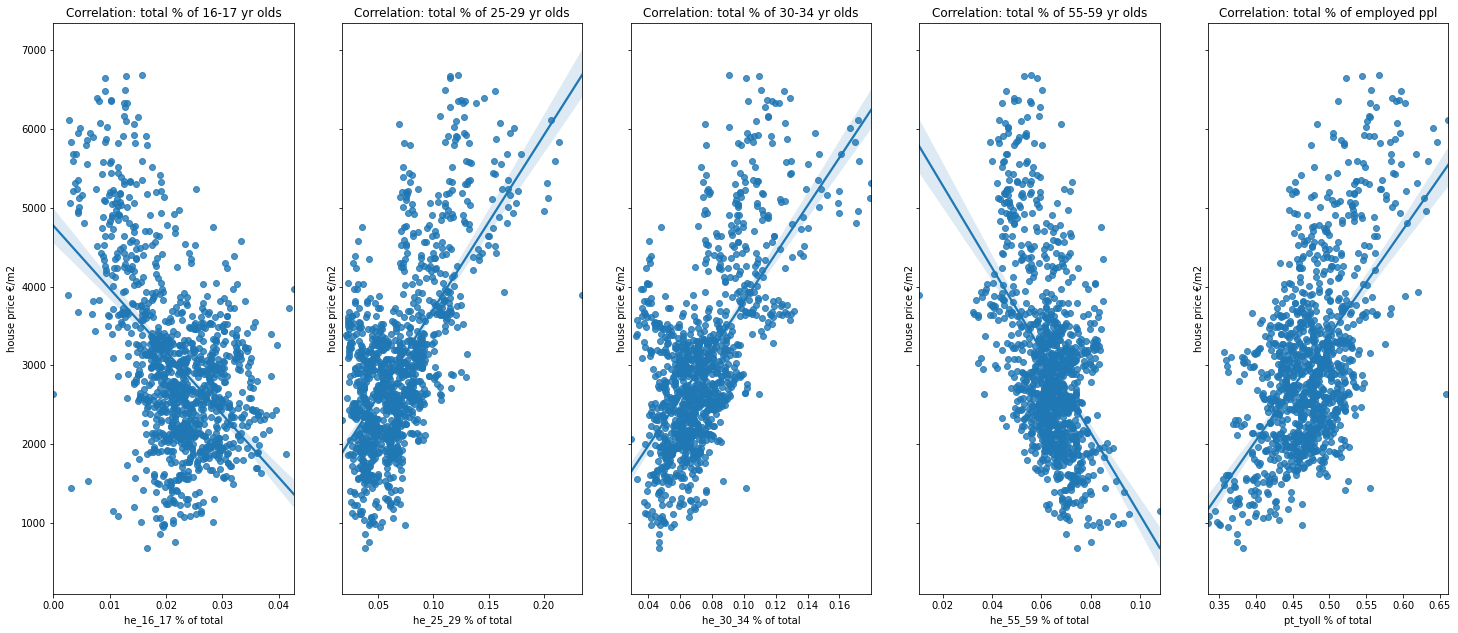

In [50]:

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, sharey=True)
fig.set_size_inches(25, 10.5)
sns.regplot(x="he_16_17 % of total", y="house price €/m2", data=division_data_pct, ax=ax1).set_title('Correlation: total % of 16-17 yr olds')
sns.regplot(x="he_25_29 % of total", y="house price €/m2", data=division_data_pct, ax=ax2).set_title('Correlation: total % of 25-29 yr olds')
sns.regplot(x="he_30_34 % of total", y="house price €/m2", data=division_data_pct, ax=ax3).set_title('Correlation: total % of 30-34 yr olds')
sns.regplot(x="he_55_59 % of total", y="house price €/m2", data=division_data_pct, ax=ax4).set_title('Correlation: total % of 55-59 yr olds')
sns.regplot(x="pt_tyoll % of total", y="house price €/m2", data=division_data_pct, ax=ax5).set_title('Correlation: total % of employed ppl')

Here you can visually see the correlation between the independent variable and dependent variable house price €/m2. Lets look at what the outliers are. For the variables that have positive correlation, we want datapoints that have low €/m2 but are strong in the independent variable, so situated in the bottom right of the graph. For negative correlation pairs we want to gather the points with low price and low independent variable, so situated in the bottom left of the graph. 

In [51]:
# un tag to get the outliers of showing in the graph. Decided this is not relevant. 
#outliers=division_data_pct[(division_data_pct['he_16_17 % of total']<0.015)& (division_data_pct['house price €/m2']<3200)]  #Where amount of 16-17yr olds is less than 1.5% and price is less than 3200€/m2.
#temp=division_data_pct[(division_data_pct['he_25_29 % of total']>0.15)& (division_data_pct['house price €/m2']<4000)]  #Where amount of 25-29yr olds is more than 15% and price is less than 4000/m2.
#outliers=pd.concat([outliers,temp])
#temp=division_data_pct[(division_data_pct['he_30_34 % of total']>0.1)& (division_data_pct['house price €/m2']<3500)]  #Where amount of 30-34yr olds is more than 15% and price is less than 4000/m2.
#outliers=pd.concat([outliers,temp])
#temp=division_data_pct[(division_data_pct['he_55_59 % of total']<0.05)& (division_data_pct['house price €/m2']<3000)]  #Where amount of 55-59yr olds is less than 1.5% and price is less than 3200€/m2.
#outliers=pd.concat([outliers,temp])
#temp=division_data_pct[(division_data_pct['pt_tyoll % of total']>0.55)& (division_data_pct['house price €/m2']<3000)]  #Where amount of employed ppl is less than 1.5% and price is less than 3200€/m2.
#outliers=pd.concat([outliers,temp])
#outliers



Instead of outliers we will focus on finding which areas have a positive trend that could affect house prices later. For example increase in 25-29 year olds might forecast price increase? Reduction of 16-17year olds might also forecast price increase.

In [52]:
# Test 1: using positive correlation variables to find outlier ares that have potential for investing in.
# You can see that the biggest correlations are with he_25_29:0.490398, he_30_34:0.473333, tp_tyopy:0.481173, tp_palv_gu:0.526627,  tp_i_majo:0.510699, tp_l_kiin:0.507329,  tp_o_julk:0.490151,  tp_r_taid:0.506011
# Lets calculate the average year over year increase or decrease in these values according to zip code. After that we can use the get the average of all the year over year variable averages and use this data to 
# find potential house investment areas.


# Test 2: using negative positive correlation variables to find areas that might have cheapening prices.
# -0.122548


In [53]:
study_data.head()


posti_alue             nimi  vuosi  house price €/m2  house sales qty  \
0      04840        Hautjärvi   2013               NaN              0.0   
1      04920       Saarentaus   2013               NaN              1.0   
2      05800  Hyvinkää Keskus   2013            2126.0            254.0   
3      05820    Mustamännistö   2013            1720.0             36.0   
4      07560   Pukkila Keskus   2013               NaN              4.0   

   he_vakiy  he_16_17  he_25_29  he_30_34  he_55_59  pt_tyoll  \
0     254.0       8.0       7.0      15.0      22.0     123.0   
1     336.0       9.0      13.0      20.0      27.0     167.0   
2    9268.0     153.0     592.0     531.0     632.0    3928.0   
3    5076.0     160.0     215.0     318.0     336.0    2321.0   
4    1421.0      34.0      51.0      69.0     105.0     624.0   

                                            geometry  
0  MULTIPOLYGON (((25.51447040926808 60.746112283...  
1  MULTIPOLYGON (((25.39747116297364 60.761105463...  
2  MULTIPOLYGON (((24.90562469978996 60.700248112...  
3  MULTIPOLYGON (((24.9821793689926 60.6851616535...  
4  MULTIPOLYGON (((25.64272937252556 60.595477043...

In [54]:
# YEAR OVER YEAR GROWTH OF VARIABLES


# For loop to get the years available for each zip code
# 1. The loop goes through every zip code individually
# 2. creates list of years for that zip code
# 4. Get the year over year growth/decrease for each variable
# 4.b If only one year Nan
# 4.a If consecutive years, gets the year over year growth/decrease
# 4.b If gap years, gets the average growth (2013:1%, 2015:3% = 2014:2%)

cols= ['house price €/m2', 'house sales qty', 'he_vakiy', 'he_16_17', 'he_25_29', 'he_30_34', 'he_55_59', 'pt_tyoll']
# create new columns that indicate they are % of total
columns = []
for col in cols:
    columns.append('{} YOY %'.format(col))
study_data[columns]=''
unique_zipcodes=np.unique(study_data['posti_alue'])
study_data=study_data.set_index(['posti_alue','vuosi'])



# For loop that populates the new Year over year columns. 
for zip in unique_zipcodes:
  years=study_data.loc[zip].index.values
  study_data.loc[(zip,years[0]),columns]=0
  for i,year in enumerate(years[1:]):  #We select everything after the first row, as the first row is the base and does not have any growth
    if year-years[i]==1:       # If consecutive years, gets the year over year growth/decrease
      to_append=(study_data.loc[(zip,year),cols]-study_data.loc[(zip,years[i]),cols])/study_data.loc[(zip,years[i]),cols]
      study_data.loc[(zip,year),columns] = to_append.values

    elif year-years[i-1]>1:  # if not consecutive years, gets the average growth 
      to_append=(study_data.loc[zip,year].mean(axis=0)-study_data.loc[(zip,years[i]),cols])/study_data.loc[(zip,years[i]),cols] 
      study_data.loc[(zip,year),columns] = to_append.values

study_data[columns]=study_data[columns].apply(pd.to_numeric)
study_data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

nimi  house price €/m2  house sales qty  \
posti_alue vuosi                                                       
04840      2013         Hautjärvi               NaN              0.0   
04920      2013        Saarentaus               NaN              1.0   
05800      2013   Hyvinkää Keskus            2126.0            254.0   
05820      2013     Mustamännistö            1720.0             36.0   
07560      2013    Pukkila Keskus               NaN              4.0   

                  he_vakiy  he_16_17  he_25_29  he_30_34  he_55_59  pt_tyoll  \
posti_alue vuosi                                                               
04840      2013      254.0       8.0       7.0      15.0      22.0     123.0   
04920      2013      336.0       9.0      13.0      20.0      27.0     167.0   
05800      2013     9268.0     153.0     592.0     531.0     632.0    3928.0   
05820      2013     5076.0     160.0     215.0     318.0     336.0    2321.0   
07560      2013     1421.0      34.0      51.0      69.0     105.0     624.0   

                                                           geometry  \
posti_alue vuosi                                                      
04840      2013   MULTIPOLYGON (((25.51447040926808 60.746112283...   
04920      2013   MULTIPOLYGON (((25.39747116297364 60.761105463...   
05800      2013   MULTIPOLYGON (((24.90562469978996 60.700248112...   
05820      2013   MULTIPOLYGON (((24.9821793689926 60.6851616535...   
07560      2013   MULTIPOLYGON (((25.64272937252556 60.595477043...   

                  house price €/m2 YOY %  house sales qty YOY %  \
posti_alue vuosi                                                  
04840      2013                      0.0                    0.0   
04920      2013                      0.0                    0.0   
05800      2013                      0.0                    0.0   
05820      2013                      0.0                    0.0   
07560      2013                      0.0                    0.0   

                  he_vakiy YOY %  he_16_17 YOY %  he_25_29 YOY %  \
posti_alue vuosi                                                   
04840      2013              0.0             0.0             0.0   
04920      2013              0.0             0.0             0.0   
05800      2013              0.0             0.0             0.0   
05820      2013              0.0             0.0             0.0   
07560      2013              0.0             0.0             0.0   

                  he_30_34 YOY %  he_55_59 YOY %  pt_tyoll YOY %  
posti_alue vuosi                                                  
04840      2013              0.0             0.0             0.0  
04920      2013              0.0             0.0             0.0  
05800      2013              0.0             0.0             0.0  
05820      2013              0.0             0.0             0.0  
07560      2013              0.0             0.0             0.0

In [55]:
# To find out if the independent variables are the causation for the prices to decrease or lower, we will next get the average annual growth and decrease of the demographic data. 
# Then we will do the same correlation analysis and see if there is strong correlation with the growth and decrease of the variables.
# For loop that populates the average column to the 2018 row of each zip code

cols= ['house price €/m2', 'house sales qty', 'he_vakiy', 'he_16_17', 'he_25_29', 'he_30_34', 'he_55_59', 'pt_tyoll']
study_data_2018=study_data.reset_index(['posti_alue','vuosi'])
study_data_2018=study_data_2018.drop(columns,axis=1)
study_data_2018=study_data_2018[study_data_2018['vuosi']==2018]

# create new columns that indicate they are % of total
columns1 = []
for col in cols:
    columns1.append('{} YOY AVG %'.format(col))
study_data_2018[columns1]=''
unique_zipcodes=np.unique(study_data_2018['posti_alue'])
study_data_2018=study_data_2018.set_index(['posti_alue','vuosi'])

for zip in unique_zipcodes:
  to_append=study_data.loc[zip][columns].mean(axis=0)
  study_data_2018.loc[zip,columns1] = to_append.values
study_data_2018[columns1]=study_data_2018[columns1].apply(pd.to_numeric)

In [56]:
study_data_2018.corr()

house price €/m2  house sales qty  he_vakiy  \
house price €/m2                    1.000000         0.414259  0.175486   
house sales qty                     0.414259         1.000000  0.866655   
he_vakiy                            0.175486         0.866655  1.000000   
he_16_17                           -0.161190         0.582514  0.879439   
he_25_29                            0.452843         0.907347  0.865656   
he_30_34                            0.423662         0.923904  0.909224   
he_55_59                            0.034677         0.781432  0.968279   
pt_tyoll                            0.293707         0.903569  0.982048   
house price €/m2 YOY AVG %          0.722621         0.348480  0.212228   
house sales qty YOY AVG %           0.020352        -0.129410 -0.105556   
he_vakiy YOY AVG %                  0.241363        -0.014308  0.037895   
he_16_17 YOY AVG %                  0.144471        -0.092693 -0.060919   
he_25_29 YOY AVG %                  0.133997        -0.084327 -0.061501   
he_30_34 YOY AVG %                  0.221206         0.037121  0.066586   
he_55_59 YOY AVG %                  0.212331        -0.160582 -0.089716   
pt_tyoll YOY AVG %                  0.274327        -0.021727  0.028811   

                            he_16_17  he_25_29  he_30_34  he_55_59  pt_tyoll  \
house price €/m2           -0.161190  0.452843  0.423662  0.034677  0.293707   
house sales qty             0.582514  0.907347  0.923904  0.781432  0.903569   
he_vakiy                    0.879439  0.865656  0.909224  0.968279  0.982048   
he_16_17                    1.000000  0.556171  0.628365  0.923460  0.810032   
he_25_29                    0.556171  1.000000  0.984745  0.747641  0.918578   
he_30_34                    0.628365  0.984745  1.000000  0.804898  0.952279   
he_55_59                    0.923460  0.747641  0.804898  1.000000  0.923929   
pt_tyoll                    0.810032  0.918578  0.952279  0.923929  1.000000   
house price €/m2 YOY AVG % -0.001255  0.370493  0.358476  0.122049  0.281927   
house sales qty YOY AVG %  -0.058598 -0.099260 -0.103401 -0.115737 -0.095833   
he_vakiy YOY AVG %         -0.023459  0.114157  0.090945 -0.012364  0.070920   
he_16_17 YOY AVG %         -0.055264 -0.004462 -0.026284 -0.108434 -0.036800   
he_25_29 YOY AVG %         -0.087473 -0.005742 -0.028171 -0.085619 -0.041415   
he_30_34 YOY AVG %         -0.012522  0.137347  0.121947  0.034500  0.086729   
he_55_59 YOY AVG %         -0.053748 -0.047577 -0.067553 -0.098099 -0.063457   
pt_tyoll YOY AVG %         -0.032474  0.116254  0.088126 -0.020632  0.067087   

                            house price €/m2 YOY AVG %  \
house price €/m2                              0.722621   
house sales qty                               0.348480   
he_vakiy                                      0.212228   
he_16_17                                     -0.001255   
he_25_29                                      0.370493   
he_30_34                                      0.358476   
he_55_59                                      0.122049   
pt_tyoll                                      0.281927   
house price €/m2 YOY AVG %                    1.000000   
house sales qty YOY AVG %                     0.097542   
he_vakiy YOY AVG %                            0.179979   
he_16_17 YOY AVG %                            0.078895   
he_25_29 YOY AVG %                            0.179417   
he_30_34 YOY AVG %                            0.176830   
he_55_59 YOY AVG %                            0.084522   
pt_tyoll YOY AVG %                            0.166939   

                            house sales qty YOY AVG %  he_vakiy YOY AVG %  \
house price €/m2                             0.020352            0.241363   
house sales qty                             -0.129410           -0.014308   
he_vakiy                                    -0.105556            0.037895   
he_16_17                                    -0.058598           -0.023459   
he_25_29           

Text(0.5, 1.0, 'Correlation: YOY AVG % of emplyd ppl')

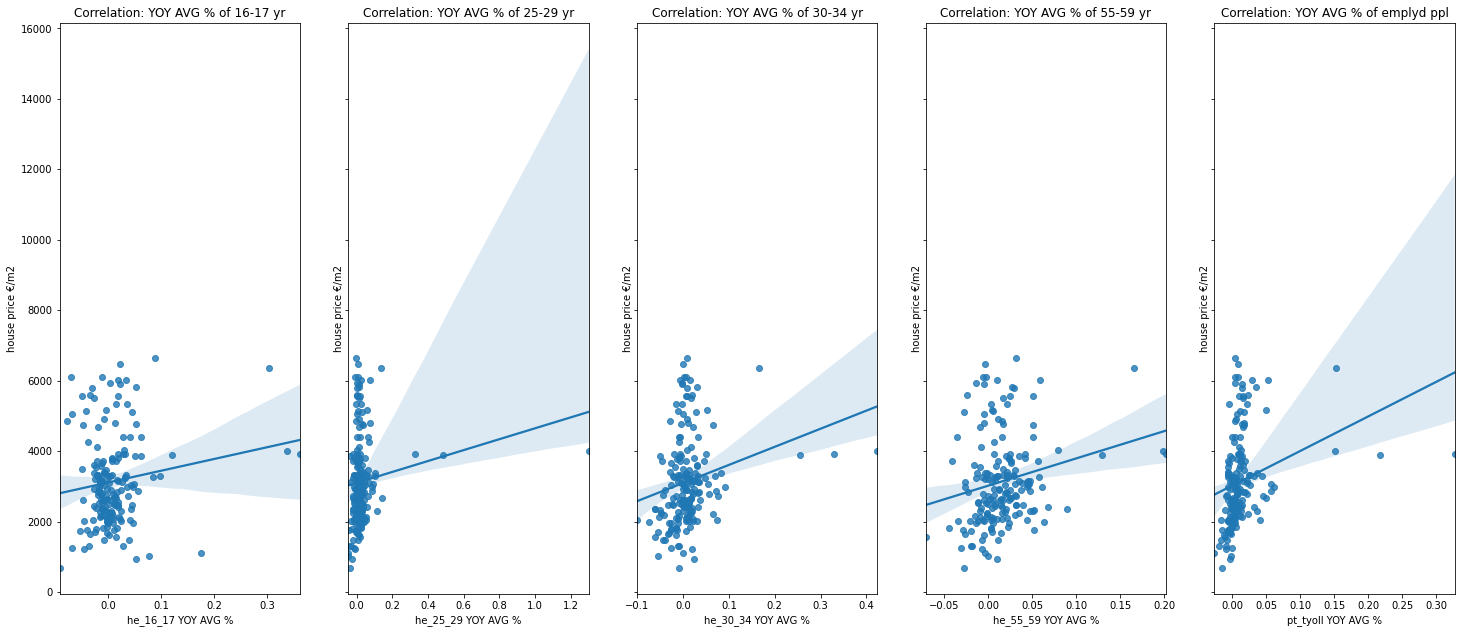

In [57]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, sharey=True)
fig.set_size_inches(25, 10.5)
sns.regplot(x="he_16_17 YOY AVG %", y="house price €/m2", data=study_data_2018, ax=ax1).set_title('Correlation: YOY AVG % of 16-17 yr')
sns.regplot(x="he_25_29 YOY AVG %", y="house price €/m2", data=study_data_2018, ax=ax2).set_title('Correlation: YOY AVG % of 25-29 yr')
sns.regplot(x="he_30_34 YOY AVG %", y="house price €/m2", data=study_data_2018, ax=ax3).set_title('Correlation: YOY AVG % of 30-34 yr')
sns.regplot(x="he_55_59 YOY AVG %", y="house price €/m2", data=study_data_2018, ax=ax4).set_title('Correlation: YOY AVG % of 55-59 yr')
sns.regplot(x="pt_tyoll YOY AVG %", y="house price €/m2", data=study_data_2018, ax=ax5).set_title('Correlation: YOY AVG % of emplyd ppl')

There doesn't seem to be any correlation between the growth of the independent variables and the dependent variable price. We can conclude that these variables are not in a causative relationship with the price. 

### Second try with different data
As the previous exploratory anaylsis was not satisfactory, I decided to explore a different set of data. This time the educational demographics and the data is from 

In [58]:
%cd /content/drive/MyDrive/Colab files/Capstone/tilastot
newdata_2019=gpd.read_file("newdata_2019.geojson")
newdata_2019.head()

/content/drive/MyDrive/Colab files/Capstone/tilastot


posti_alue house price €/m2 house sales qty          nimi  he_vakiy  \
0      00190               ..               1   Suomenlinna     748.0   
1      00200             6102             417   Lauttasaari   15904.0   
2      00210             5976             252    Vattuniemi    8563.0   
3      00220               ..              19    Jätkäsaari    7722.0   
4      00240             5063              73  Länsi-Pasila    5477.0   

   ko_perus  ko_koul  ko_yliop  ko_ammat  ko_al_kork  ko_yl_kork   hr_ktu  \
0      81.0    459.0      70.0     151.0        88.0       150.0  30364.0   
1    1421.0  11866.0    1713.0    2663.0      2611.0      4879.0  37708.0   
2     769.0   6305.0     699.0    1586.0      1326.0      2694.0  42418.0   
3     785.0   5646.0    1105.0    1405.0      1489.0      1647.0  29708.0   
4     818.0   3978.0     532.0    1400.0       931.0      1115.0  27285.0   

    hr_mtu  hr_pi_tul  hr_ke_tul  hr_hy_tul       hr_ovy  \
0  27688.0       87.0      269.0      184.0   16396804.0   
1  29703.0     1749.0     6047.0     5491.0  501030910.0   
2  32861.0      793.0     2830.0     3451.0  300067192.0   
3  26016.0     1180.0     3251.0     2000.0  191048958.0   
4  25322.0      761.0     2796.0     1239.0  130858142.0   

                                            geometry  
0  MULTIPOLYGON (((24.98857 60.13781, 24.98810 60...  
1  MULTIPOLYGON (((24.87156 60.16438, 24.87260 60...  
2  MULTIPOLYGON (((24.88720 60.15567, 24.88733 60...  
3  MULTIPOLYGON (((24.92439 60.15969, 24.92367 60...  
4  MULTIPOLYGON (((24.93401 60.21531, 24.93481 60...

In [59]:
# need to get rid of missing datapoints, mostly missing price data for some locations.
division_data_2019=newdata_2019
division_data_2019['house price €/m2'].replace(0, np.nan, inplace=True)
division_data_2019['house price €/m2'].replace('..', np.nan, inplace=True)
division_data_2019=division_data_2019.dropna().reset_index(drop=True)

In [60]:
division_data_temp=division_data_2019.drop(['posti_alue', 'nimi', 'hr_ovy','hr_ktu' ,'hr_mtu', 'house price €/m2', 'house sales qty','geometry','hr_pi_tul','hr_ke_tul' ,'hr_hy_tul'],axis=1)  


# create new columns that indicate they are % of total
columns = ['he_vakiy']
for ind in np.arange(1,len(division_data_temp.columns)):
    columns.append('{} % of total'.format(division_data_temp.columns[ind]))
# create a new dataframe
division_data_pct = pd.DataFrame(columns=columns)
division_data_pct['he_vakiy'] = division_data_2019['he_vakiy']

# Populate the new columns with the pct data
for ind in np.arange(1,len(division_data_temp.columns)):
    division_data_pct[division_data_pct.columns[ind]] = division_data_temp.iloc[:,ind] /  division_data_temp['he_vakiy'] 

# Lets put back the columns that we took out except geomtery
division_data_pct['nimi'] = division_data_2019['nimi'] 
division_data_pct['posti_alue'] = division_data_2019['posti_alue'] 
division_data_pct['house price €/m2'] = division_data_2019['house price €/m2'] 
division_data_pct['house sales qty'] = division_data_2019['house sales qty'] 
division_data_pct[['house sales qty','house price €/m2']]=division_data_pct[['house sales qty','house price €/m2']].apply(pd.to_numeric)
division_data_pct.head()


he_vakiy  ko_perus % of total  ko_koul % of total  ko_yliop % of total  \
0   15904.0             0.089349            0.746102             0.107709   
1    8563.0             0.089805            0.736307             0.081630   
2    5477.0             0.149352            0.726310             0.097133   
3   11503.0             0.094758            0.788490             0.139963   
4    5603.0             0.129395            0.768160             0.127253   

   ko_ammat % of total  ko_al_kork % of total  ko_yl_kork % of total  \
0             0.167442               0.164173               0.306778   
1             0.185215               0.154852               0.314609   
2             0.255614               0.169984               0.203579   
3             0.187255               0.173868               0.287403   
4             0.171337               0.164912               0.304658   

           nimi posti_alue  house price €/m2  house sales qty  
0   Lauttasaari      00200              6102              417  
1    Vattuniemi      00210              5976              252  
2  Länsi-Pasila      00240              5063               73  
3    Taka-Töölö      00250              6629              368  
4   Keski-Töölö      00260              6818              147

In [61]:
division_data_pct.corr()   

he_vakiy  ko_perus % of total  ko_koul % of total  \
he_vakiy               1.000000             0.189015            0.047821   
ko_perus % of total    0.189015             1.000000           -0.628328   
ko_koul % of total     0.047821            -0.628328            1.000000   
ko_yliop % of total    0.233537            -0.365781            0.781003   
ko_ammat % of total   -0.128400             0.564512           -0.587948   
ko_al_kork % of total  0.120639            -0.653871            0.852208   
ko_yl_kork % of total  0.030911            -0.691324            0.797658   
house price €/m2       0.218313            -0.530921            0.792616   
house sales qty        0.797039             0.028775            0.411555   

                       ko_yliop % of total  ko_ammat % of total  \
he_vakiy                          0.233537            -0.128400   
ko_perus % of total              -0.365781             0.564512   
ko_koul % of total                0.781003            -0.587948   
ko_yliop % of total               1.000000            -0.770621   
ko_ammat % of total              -0.770621             1.000000   
ko_al_kork % of total             0.754018            -0.700344   
ko_yl_kork % of total             0.745416            -0.911103   
house price €/m2                  0.875469            -0.839137   
house sales qty                   0.470456            -0.268711   

                       ko_al_kork % of total  ko_yl_kork % of total  \
he_vakiy                            0.120639               0.030911   
ko_perus % of total                -0.653871              -0.691324   
ko_koul % of total                  0.852208               0.797658   
ko_yliop % of total                 0.754018               0.745416   
ko_ammat % of total                -0.700344              -0.911103   
ko_al_kork % of total               1.000000               0.732974   
ko_yl_kork % of total               0.732974               1.000000   
house price €/m2                    0.809136               0.846960   
house sales qty                     0.391721               0.282394   

                       house price €/m2  house sales qty  
he_vakiy                       0.218313         0.797039  
ko_perus % of total           -0.530921         0.028775  
ko_koul % of total             0.792616         0.411555  
ko_yliop % of total            0.875469         0.470456  
ko_ammat % of total           -0.839137        -0.268711  
ko_al_kork % of total          0.809136         0.391721  
ko_yl_kork % of total          0.846960         0.282394  
house price €/m2               1.000000         0.437763  
house sales qty                0.437763         1.000000

Text(0.5, 1.0, 'Correlation: Higher level uni degr.')

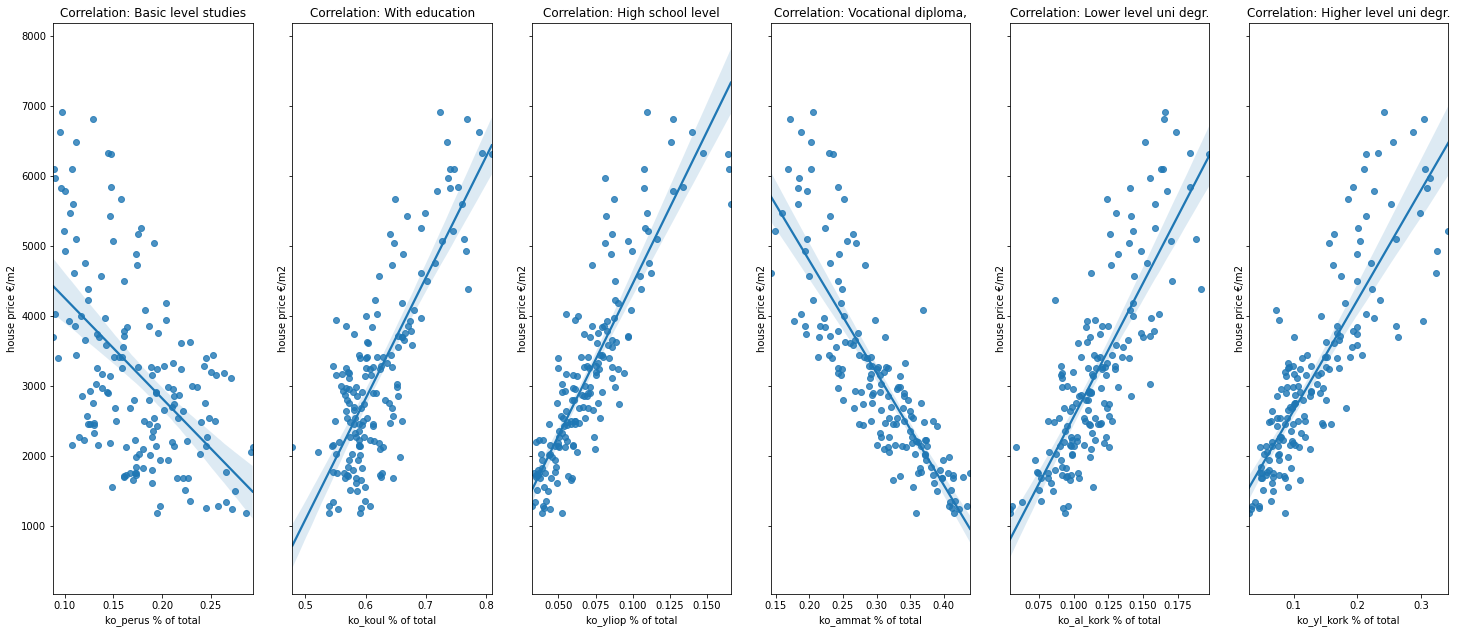

In [62]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(ncols=6, sharey=True)
fig.set_size_inches(25, 10.5)
sns.regplot(x="ko_perus % of total", y="house price €/m2", data=division_data_pct, ax=ax1).set_title('Correlation: Basic level studies')
sns.regplot(x="ko_koul % of total", y="house price €/m2", data=division_data_pct, ax=ax2).set_title('Correlation: With education')
sns.regplot(x="ko_yliop % of total", y="house price €/m2", data=division_data_pct, ax=ax3).set_title('Correlation: High school level')
sns.regplot(x="ko_ammat % of total", y="house price €/m2", data=division_data_pct, ax=ax4).set_title('Correlation: Vocational diploma,')
sns.regplot(x="ko_al_kork % of total", y="house price €/m2", data=division_data_pct, ax=ax5).set_title('Correlation: Lower level uni degr.')
sns.regplot(x="ko_yl_kork % of total", y="house price €/m2", data=division_data_pct, ax=ax6).set_title('Correlation: Higher level uni degr.')


This variables are very promising due to the high correlation. Lets move to the next phase and look for areas that have outliers.


#### Lets gather outliers from the data and see if there are any hidden opportunities.

Inhabitants portion of people with education as potential predictor variable of housing price


(0.0, 7240.4382783294695)

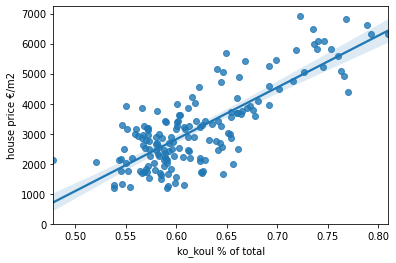

In [63]:
print("Inhabitants portion of people with education as potential predictor variable of housing price")
sns.regplot(x="ko_koul % of total", y="house price €/m2", data=division_data_pct)
plt.ylim(0,)

There are some outliers at the 5000€ mark that we can take to our outlier list.

In [64]:
outliers=division_data_pct[(division_data_pct['ko_koul % of total']>0.75)& (division_data_pct['ko_koul % of total']<0.79)& (division_data_pct['house price €/m2']<5000)]

Inhabitants portion of people with basic level education as potential predictor variable of housing price


(0.0, 7206.351174818749)

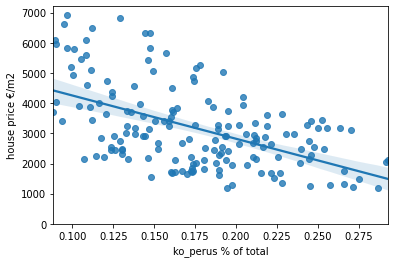

In [65]:
print("Inhabitants portion of people with basic level education as potential predictor variable of housing price")
sns.regplot(x="ko_perus % of total", y="house price €/m2", data=division_data_pct)
plt.ylim(0,)

Here we can take the outliers below 3000€ and have less than 12.5% population with basic level education. 

In [66]:
temp= division_data_pct[(division_data_pct['ko_perus % of total']<0.125)& (division_data_pct['house price €/m2']<3000)]
outliers=pd.concat([outliers,temp])

Inhabitants portion of people with high school education as potential predictor variable of housing price


(0.0, 8238.319118559195)

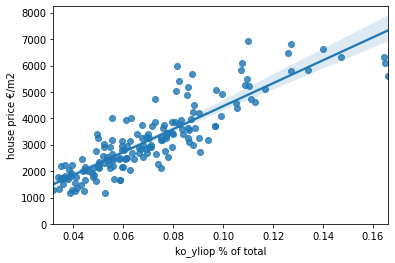

In [67]:
print("Inhabitants portion of people with high school education as potential predictor variable of housing price")
sns.regplot(x="ko_yliop % of total", y="house price €/m2", data=division_data_pct)
plt.ylim(0,)

No outliers here.

Inhabitants portion of people with vocational diploma as potential predictor variable of housing price


(0.0, 7224.533636458133)

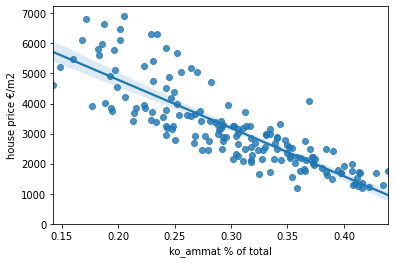

In [68]:
print("Inhabitants portion of people with vocational diploma as potential predictor variable of housing price")
sns.regplot(x="ko_ammat % of total", y="house price €/m2", data=division_data_pct)
plt.ylim(0,)

In the above graph you can see some datapoint as decent outliers. Because the amount of inhabitants with vocational diploma negatively corresponds to the housing prices, we can predict that the less people with vocational diploma the higher the prices should be. \
Lets find out what these location is. 

In [69]:
temp=division_data_pct[(division_data_pct['ko_ammat % of total']<0.20)& (division_data_pct['house price €/m2']<4100)]
outliers=pd.concat([outliers,temp])

Inhabitants portion of people with lower level university degree as potential predictor variable of housing price


(0.0, 7236.324124098402)

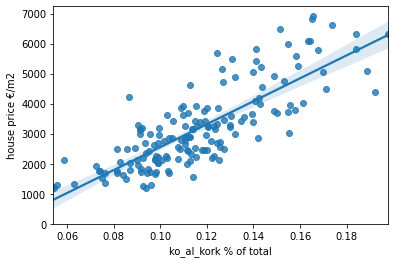

In [70]:
print("Inhabitants portion of people with lower level university degree as potential predictor variable of housing price")
sns.regplot(x="ko_al_kork % of total", y="house price €/m2", data=division_data_pct)
plt.ylim(0,)

In [71]:
temp=division_data_pct[(division_data_pct['ko_al_kork % of total']>0.143)& (division_data_pct['house price €/m2']<4400)]
outliers=pd.concat([outliers,temp])

Inhabitants portion of people with upper level university degree as potential predictor variable of housing price


(0.0, 7266.024638683945)

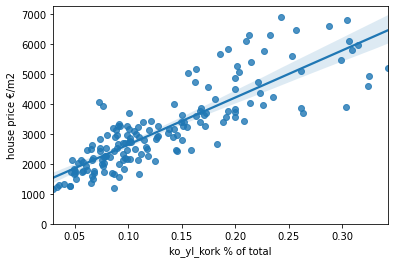

In [72]:
print("Inhabitants portion of people with upper level university degree as potential predictor variable of housing price")
sns.regplot(x="ko_yl_kork % of total", y="house price €/m2", data=division_data_pct)
plt.ylim(0,)

In [73]:
temp=division_data_pct[(division_data_pct['ko_yl_kork % of total']>0.25)& (division_data_pct['house price €/m2']<5000)]
outliers=pd.concat([outliers,temp])

In [74]:
# Here we have all the outlier areas gathered in one list. Later these outliers will be shown on the map
outliers=pd.merge(outliers,division_data_2019[['posti_alue','geometry']],on=['posti_alue'])
outliers

he_vakiy  ko_perus % of total  ko_koul % of total  ko_yliop % of total  \
0      911.0             0.124040            0.769484             0.105379   
1      911.0             0.124040            0.769484             0.105379   
2     5344.0             0.100674            0.766280             0.099551   
3     5344.0             0.100674            0.766280             0.099551   
4     2081.0             0.117732            0.654012             0.069198   
5     2339.0             0.114579            0.598119             0.050449   
6     3962.0             0.123423            0.645381             0.051742   
7     1965.0             0.119593            0.606616             0.036641   
8     2127.0             0.107193            0.545369             0.044664   
9     5765.0             0.123851            0.588378             0.043365   
10    2301.0             0.104302            0.673186             0.083007   
11    2301.0             0.104302            0.673186             0.083007   
12    6643.0             0.186211            0.566611             0.080686   
13    6178.0             0.133700            0.580609             0.067498   
14    3339.0             0.089847            0.619048             0.055406   
15    3339.0             0.089847            0.619048             0.055406   
16    4544.0             0.195423            0.665493             0.076364   
17    3277.0             0.141288            0.691486             0.087275   
18    2851.0             0.132585            0.651350             0.052262   
19    9812.0             0.135752            0.659906             0.096922   
20   13191.0             0.161398            0.654007             0.096808   
21   10983.0             0.161067            0.675590             0.082400   
22    1776.0             0.109234            0.691441             0.112613   
23    6643.0             0.110793            0.669728             0.072708   
24    5984.0             0.088402            0.660595             0.071524   

    ko_ammat % of total  ko_al_kork % of total  ko_yl_kork % of total  \
0              0.249177               0.192097               0.222832   
1              0.249177               0.192097               0.222832   
2              0.192927               0.148765               0.325037   
3              0.192927               0.148765               0.325037   
4              0.317636               0.141759               0.125420   
5              0.306114               0.123130               0.118427   
6              0.351590               0.125442               0.116608   
7              0.372010               0.115522               0.082443   
8              0.301363               0.097790               0.101551   
9              0.328534               0.117780               0.098699   
10             0.176445               0.109952               0.303781   
11             0.176445               0.109952               0.303781   
12             0.193587               0.124793               0.167545   
13             0.194238               0.118971               0.199903   
14             0.188080               0.161426               0.214136   
15             0.188080               0.161426               0.214136   
16             0.272887               0.148988               0.167254   
17             0.222460               0.155630               0.226121   
18             0.306559               0.155384               0.137145   
19             0.312169               0.149918               0.100897   
20             0.230233               0.154803               0.172163   
21             0.242557               0.157880               0.192752   
22             0.142455               0.112613               0.323761   
23             0.215716               0.120277               0.261027   
24             0.213737               0.112132               0.263202   

                       nimi posti_alue  house price €/m2  house sales qty  \

In [75]:
outliers_gdf = gpd.GeoDataFrame(outliers)
outliers_gdf.to_file('outliers_gdf.json', driver='GeoJSON')  

### 5. Choropleth map of results

In [77]:
# Data mangling for making the dataset fit the folium map. The geodata and outliers_gdf_map are cleaner stripped versions of the original dataset.
geodataset_2021 =gpd.read_file("paavo_postialue_tilasto_2021.geojson")
geodata=geodataset_2021[['postinumeroalue','nimi','geometry']]
pricedata_tomerge=old_price_df[['Zip', 2020]] 
pricedata_tomerge=pricedata_tomerge.rename(columns={'Zip':'postinumeroalue',2020:'2020 €/m2'}).astype(str)
pricedata_tomerge[['postinumeroalue']]=pricedata_tomerge[['postinumeroalue']].astype('str')
pricedata_tomerge['2020 €/m2']=pricedata_tomerge['2020 €/m2'].replace("..",np.nan).fillna(0).astype(int)
geodata=geodata.merge(pricedata_tomerge,on="postinumeroalue")
outliers_gdf_map=outliers_gdf[['posti_alue','geometry']]

In [78]:
# Create a color treshold for gradiation of the price data
new_scale=list(np.linspace(0,9000,6,dtype=int))
print(new_scale)

[0, 1800, 3600, 5400, 7200, 9000]


In [79]:
# Create the map and make the start location as Helsinki
m = folium.Map(location=[60.20885233280435, 24.917510308498464],
               tiles='OpenStreetMap',
               zoom_start=11,
               control_scale=True,
               prefer_canvas=True,)

#HSL area layer
folium.Choropleth(geo_data=hsl_zones_geodf,    
                  name="HSL Zones",
                  data=hsl_zones_geodf,
                  columns=['Zone','FID'],
                  key_on='feature.properties.Zone',
                  fill_color='Blues',  #You can find more fill color scales here: https://rdrr.io/cran/RColorBrewer/man/ColorBrewer.html
                  fill_opacity=0.5, 
                  line_opacity=1,
                  threshold_scale=[1,2,3,4,5],
                  line_color='blue',
                  line_weight=1,
                  interactive=False,
                  legend_name='HSL Zones A, B, C, D',
                  reset=True,).add_to(m)


# 2020 price data
pricedata_2020= folium.Choropleth(geo_data=geodata,
                  data=geodata,
                  columns=['postinumeroalue','2020 €/m2'],
                  key_on="feature.properties.postinumeroalue",
                  fill_color='YlOrRd',
                  threshold_scale=new_scale,
                  fill_opacity=0.45,
                  line_opacity=0.8,
                  line_color='white',
                  line_weight=1,
                  legend_name='Average prices of old dwellings in housing companies (eur/m2)',
                  name='2019 prices',
                  highlight=False
                 ).add_to(m)

# create another layer object for the potential good housing areas according to outliers
folium.Choropleth(geo_data=outliers_gdf_map,    
                  name="Outliers layer",
                  fill_color='purple',  #You can find more fill color scales here: https://rdrr.io/cran/RColorBrewer/man/ColorBrewer.html
                  fill_opacity=0.5, 
                  line_opacity=1,
                  line_color='purple',
                  line_weight=1,
                  interactive=True,
                  highlight=True,
                  popup='test').add_to(m)

# create another layer object for the HSL terminal markers
terminals_layer = folium.FeatureGroup(name="terminlas layer")
# add marker one by one on the map
for i in range(0,len(terminals_df)):
   folium.Marker(location=[terminals_df.iloc[i]['latitude'], terminals_df.iloc[i]['longitude']],
                 popup=terminals_df.iloc[i]['terminal'],
                 radius=1,
                 weight=0,
                 icon=folium.DivIcon(html=f"""<div style="font-family: courier new; color: blue">T</div>""")
).add_to(terminals_layer)
terminals_layer.add_to(m)

# add the layer control switch, which can now control the separate layer holding objects for the single points and roads
folium.LayerControl().add_to(m)
m

### Thank you for your interest! Hope you enjoyed!